## Predicting User Interactions Using Machine Learning 

The dataset is downloaded from https://www.kaggle.com/datasets/mkechinov/ecommerce-behavior-data-from-multi-category-store.
2019-Oct (5.5 GB) is used only.

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from matplotlib.pyplot import figure
import squarify
import matplotlib.dates as dates
import seaborn as sns


In [3]:
plt.rcParams['figure.figsize'] = (7, 5)

plt.rcParams['font.sans-serif'] = "Trebuchet MS"

# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = "sans-serif"

Since the dataset is skewed (very high number of records with view events, the dataset is balanced by sampling number of *view* events equal to the *purchase* and *cart* combined.

In [4]:
# Load the dataset
def balance_dataset(PATH):
    # Load the dataset
    df = pd.read_csv(PATH)
    
    # Calculate the combined count of cart and purchase events
    combined_count = len(df[df['event_type'].isin(['cart', 'purchase'])])
    
    # Sample an equal number of view events
    view_sampled = df[df['event_type'] == 'view'].sample(combined_count, random_state=42)
    
    # Concatenate the sampled view events with the cart and purchase events
    balanced_dataset = pd.concat([view_sampled, df[df['event_type'].isin(['cart', 'purchase'])]])
    
    return balanced_dataset

# Balance the dataset and check the distribution and head
balanced_df = balance_dataset("2019-Oct.csv")

In [5]:
balanced_df['event_type'].value_counts()

view        1669365
cart         926516
purchase     742849
Name: event_type, dtype: int64

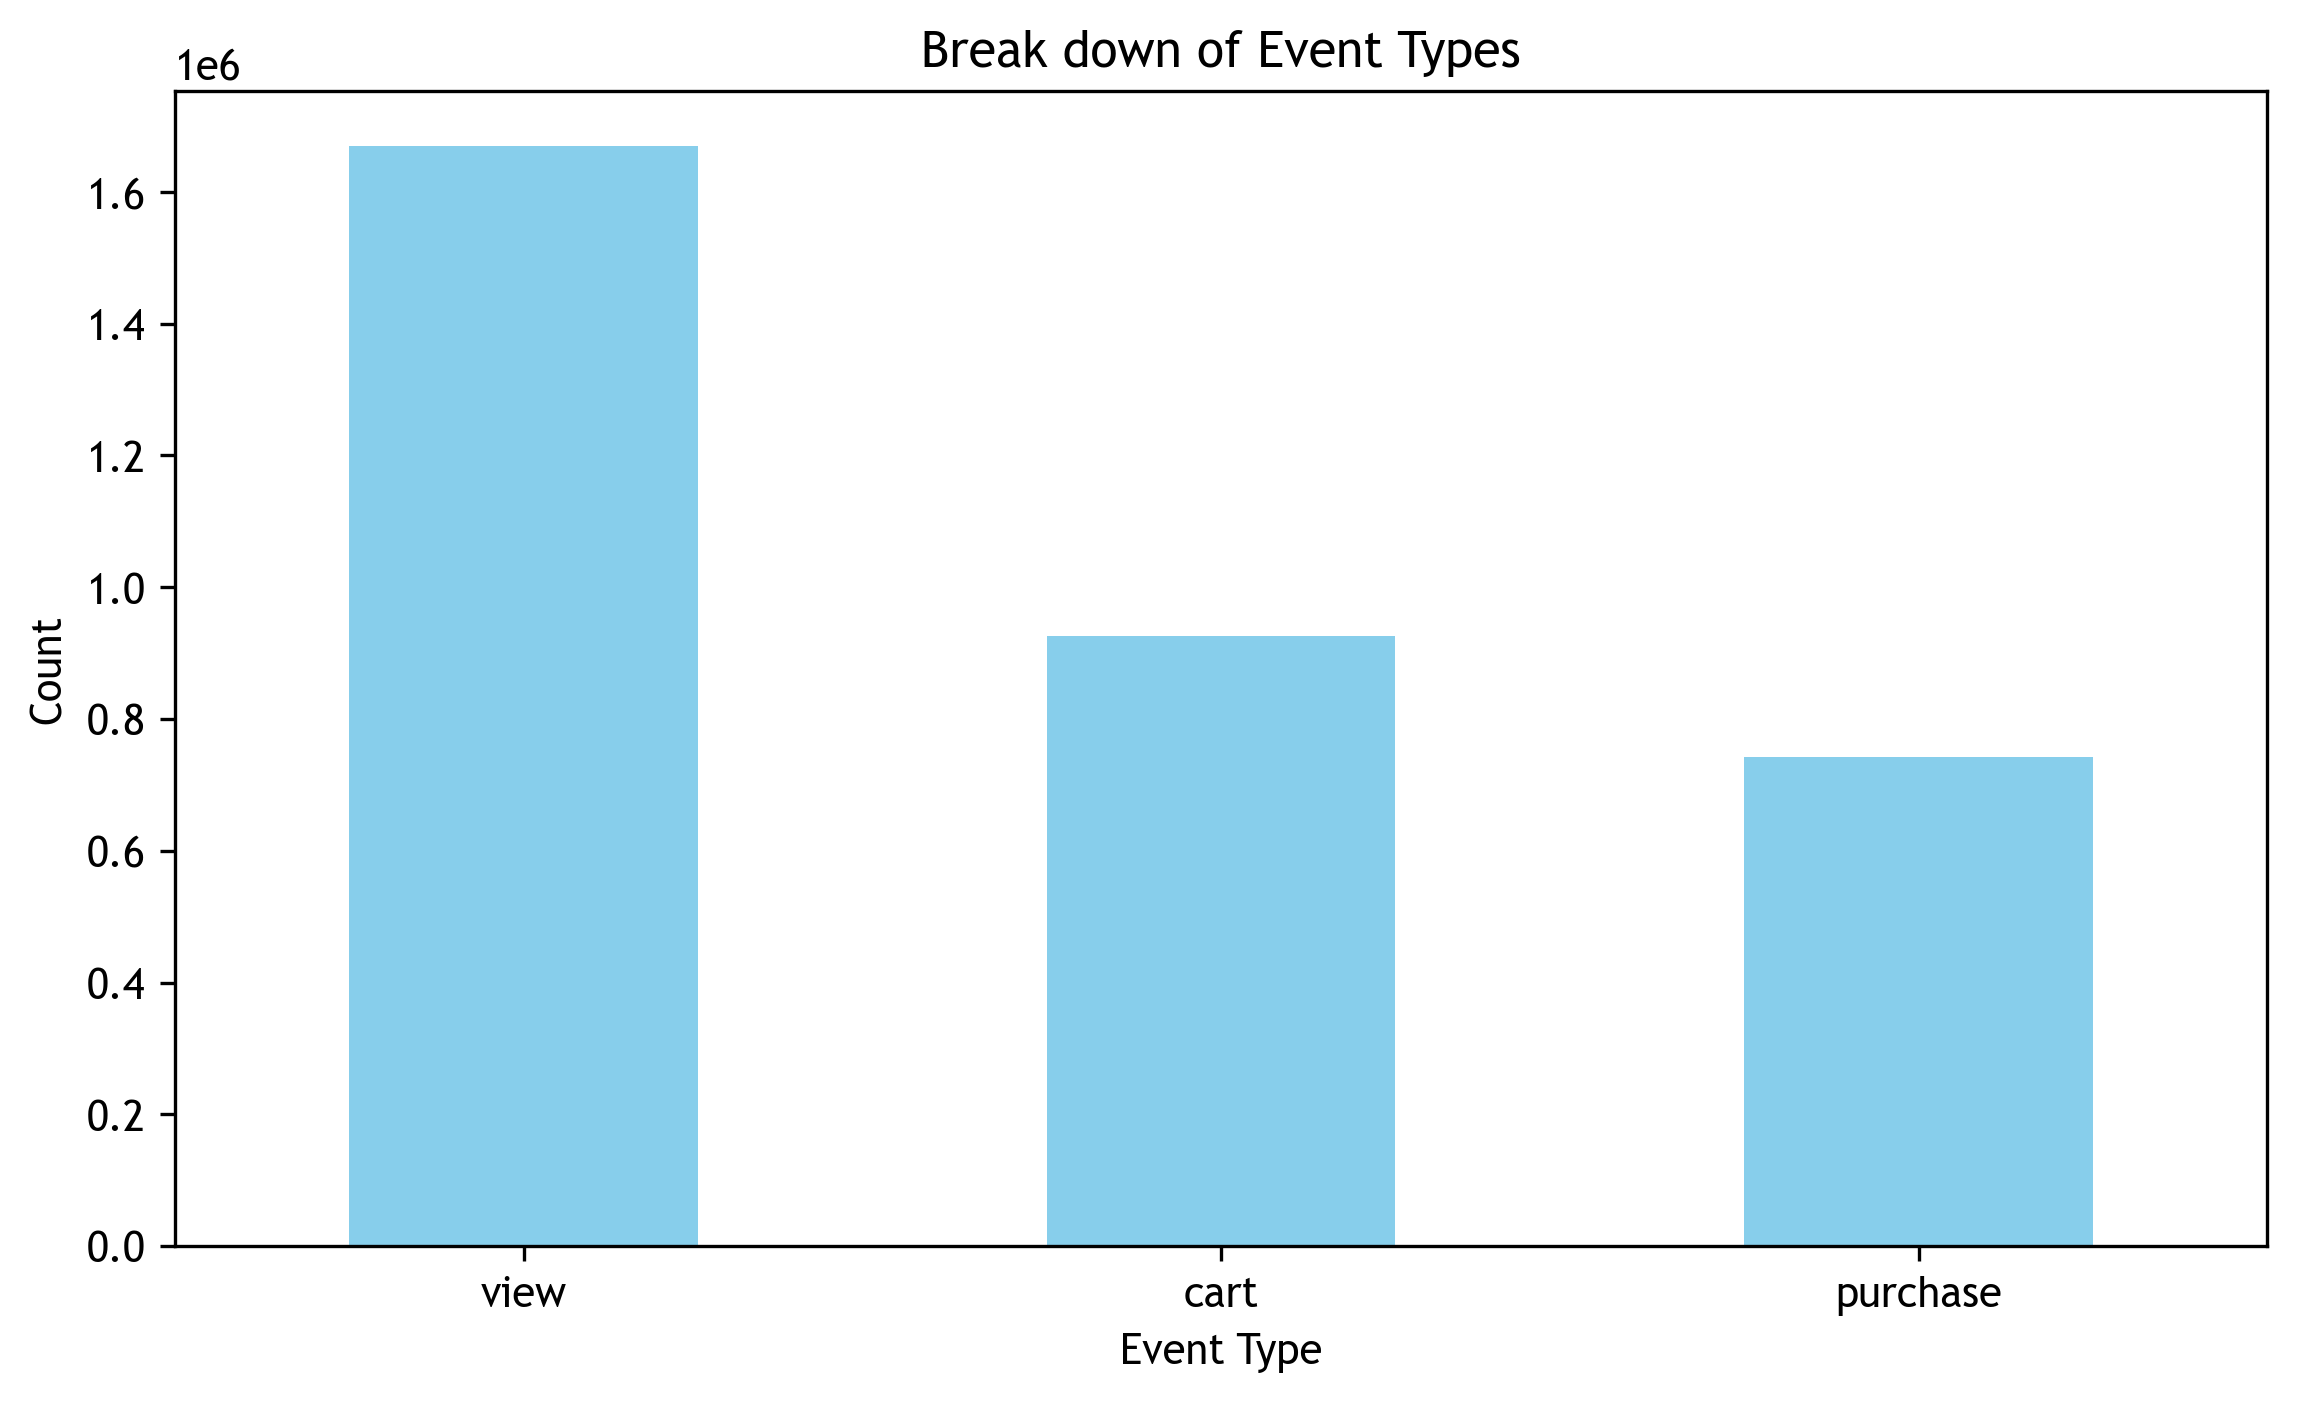

In [6]:
counts = pd.Series(balanced_df['event_type']).value_counts()

# Plot the count for event types
plt.figure(figsize = (9, 5), dpi = 300)
counts.plot(kind='bar', color='skyblue')
plt.title('Break down of Event Types')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [7]:
# Display the first few rows of the dataset
balanced_df.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
1262412,2019-10-02 01:29:21 UTC,view,1004958,2053013555631882655,electronics.smartphone,xiaomi,360.07,555653021,5293c9d7-54e7-4d9c-b495-bca17c289454
36436335,2019-10-27 07:02:02 UTC,view,3900685,2053013552326770905,appliances.environment.water_heater,ariston,100.34,564600668,246e3fd3-9a03-42f2-9dc7-c731d2a53cb3
459509,2019-10-01 09:46:17 UTC,view,34800198,2062461754293617058,NaN,NaN,34.13,514433968,e4b95905-30bd-41f2-85da-43a95c5e5673
30211947,2019-10-22 15:26:33 UTC,view,26016675,2053013562837697343,NaN,NaN,8.55,518525812,e78e0906-4bef-41f0-b4bb-41b52355b2a2
39420958,2019-10-29 12:57:21 UTC,view,1004767,2053013555631882655,electronics.smartphone,samsung,243.22,543796577,2f6edb6f-67b7-49ba-abc9-cae387581415


### Data Pre-Processing

In [8]:
# Check the shape of the dataset
balanced_df.shape

(3338730, 9)

In [9]:
# Check for missing values
balanced_df.isnull().sum()

event_time            0
event_type            0
product_id            0
category_id           0
category_code    821172
brand            323062
price                 0
user_id               0
user_session          2
dtype: int64

In [10]:
# Display dataset statistics for numerical columns
balanced_df.describe()

,product_id,category_id,price,user_id
count,3.338730e+06,3.338730e+06,3.338730e+06,3.338730e+06
mean,7.736971e+06,2.056141e+18,3.058823e+02,5.345095e+08
std,1.033058e+07,1.613769e+16,3.548429e+02,1.848512e+07
min,1.000978e+06,2.053014e+18,0.000000e+00,1.842654e+08
25%,1.004857e+06,2.053014e+18,8.263000e+01,5.162500e+08
50%,2.800641e+06,2.053014e+18,1.773500e+02,5.320237e+08
75%,1.230020e+07,2.053014e+18,3.704100e+02,5.526876e+08
max,6.050001e+07,2.175420e+18,2.574070e+03,5.662804e+08


In [11]:
# Drop the missing values
balanced_df=balanced_df.dropna(axis=0)

# Verify if there are any missing values left
balanced_df.isnull().sum()

event_time       0
event_type       0
product_id       0
category_id      0
category_code    0
brand            0
price            0
user_id          0
user_session     0
dtype: int64

### Exploratory Data Analysis

#### *How many customers visit the site?*

In [12]:
visitors = balanced_df['user_id'].nunique()
print ("Visitors: {}".format(visitors))

Visitors: 789805


In [13]:
data_slice = balanced_df.loc[:,['event_time','user_id']]
data_slice['event_time'] = data_slice['event_time'].apply(lambda s: str(s)[0:10])

In [14]:
visitors_by_date = data_slice.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'], ascending=True)

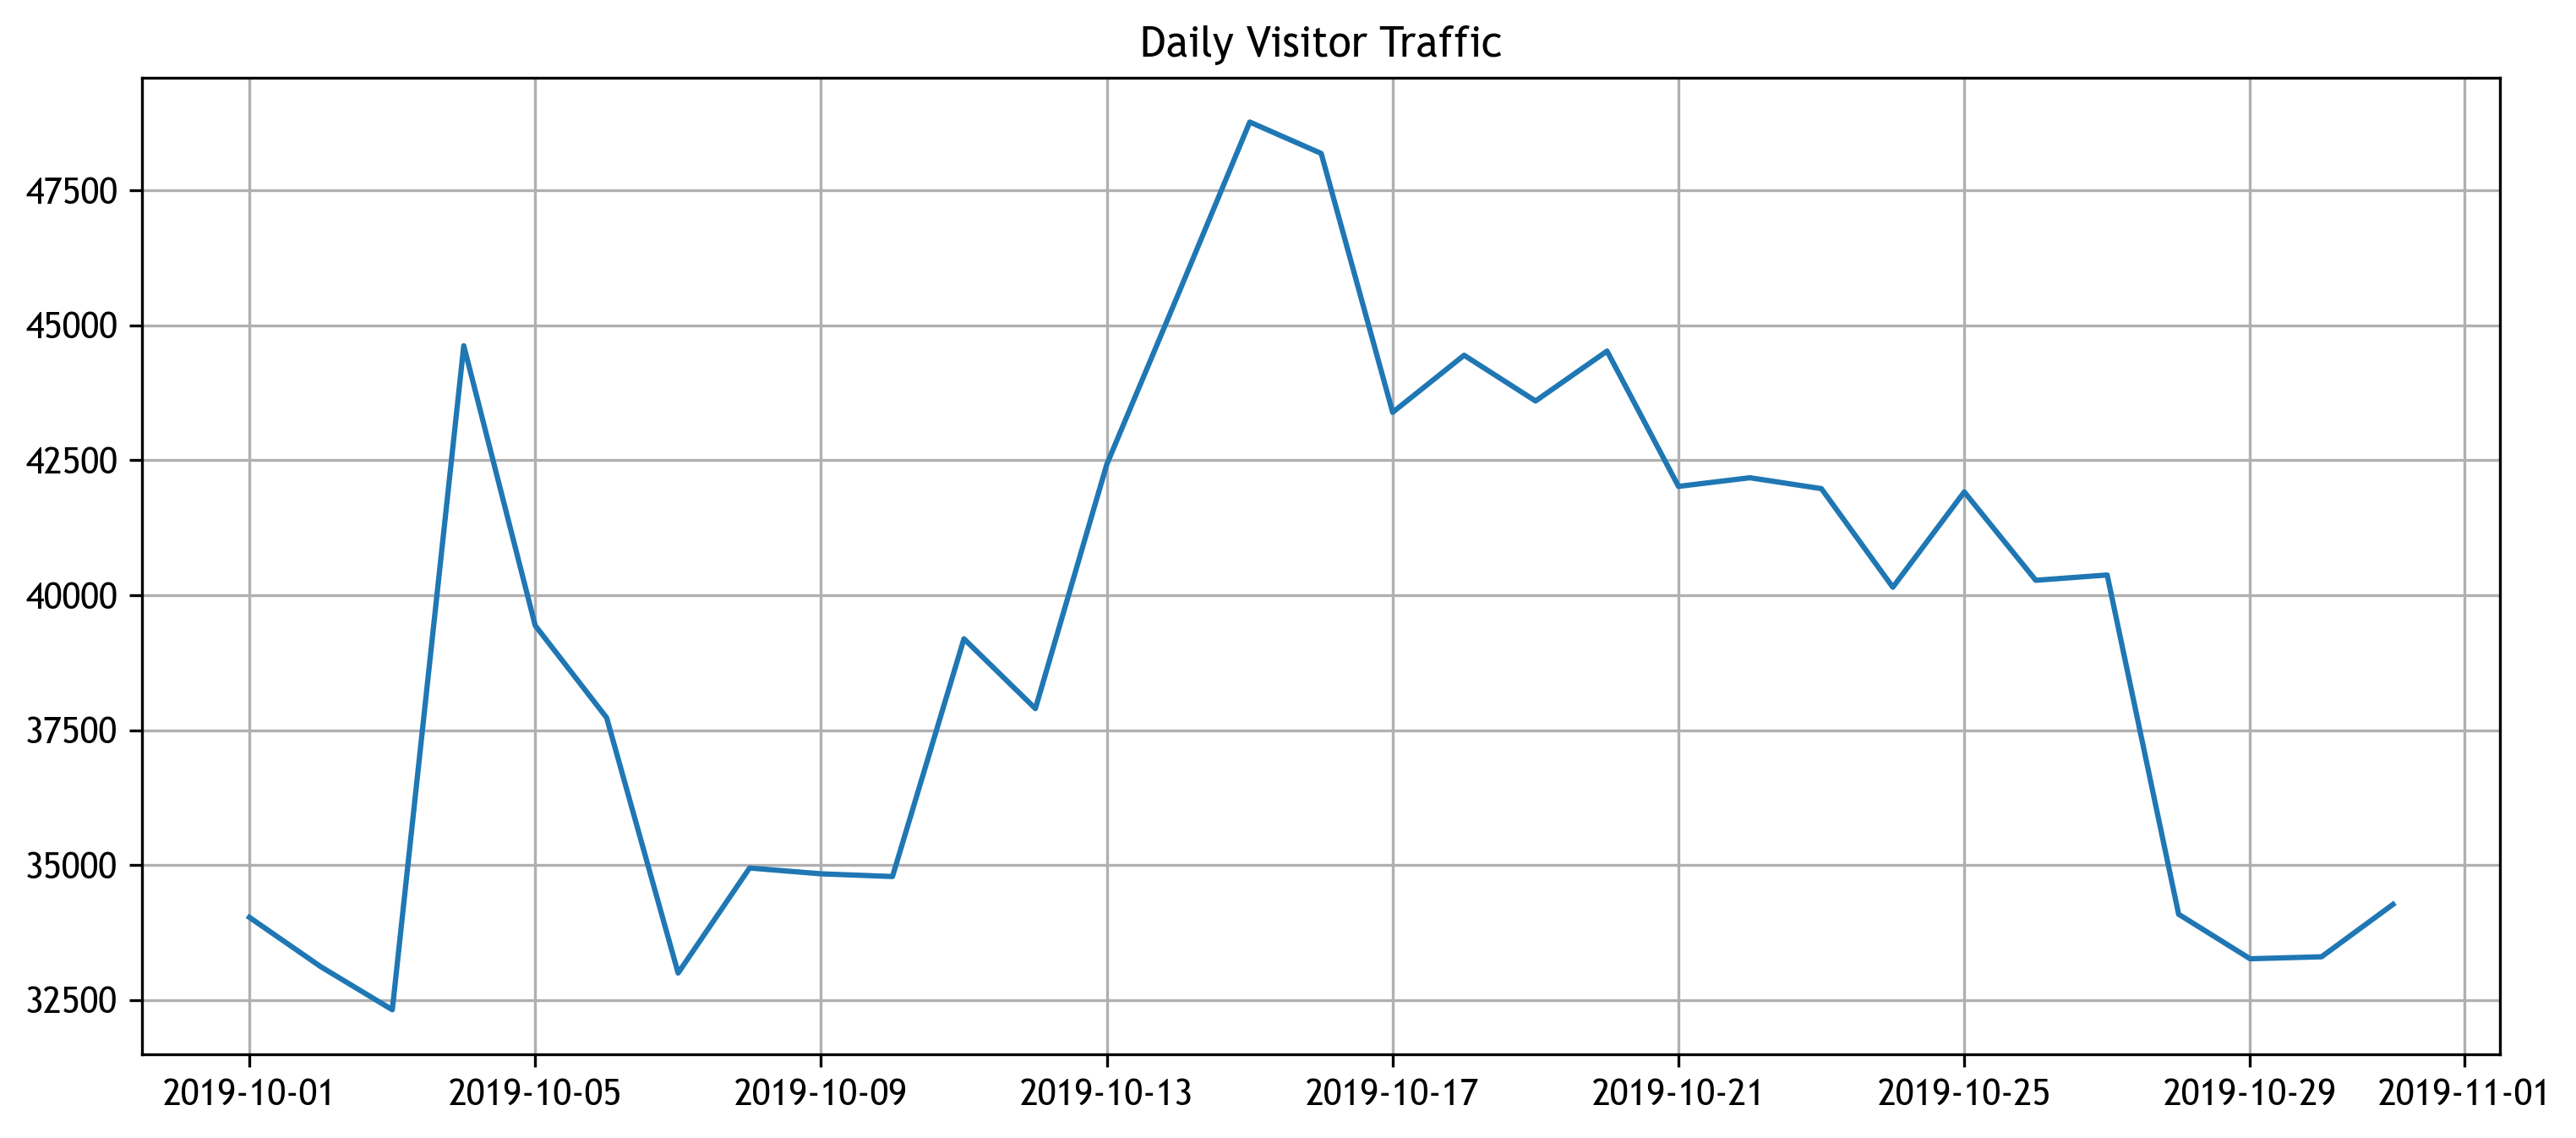

In [15]:
x = pd.Series(visitors_by_date.index.values).apply(lambda s: datetime.strptime(s, '%Y-%m-%d').date())
y = visitors_by_date['count']
plt.figure(figsize = (12, 5), dpi = 300)
plt.title('Daily Visitor Traffic')
plt.grid(True)
plt.plot(x,y)
plt.show()

#### *Which category customers interact with the most?* 

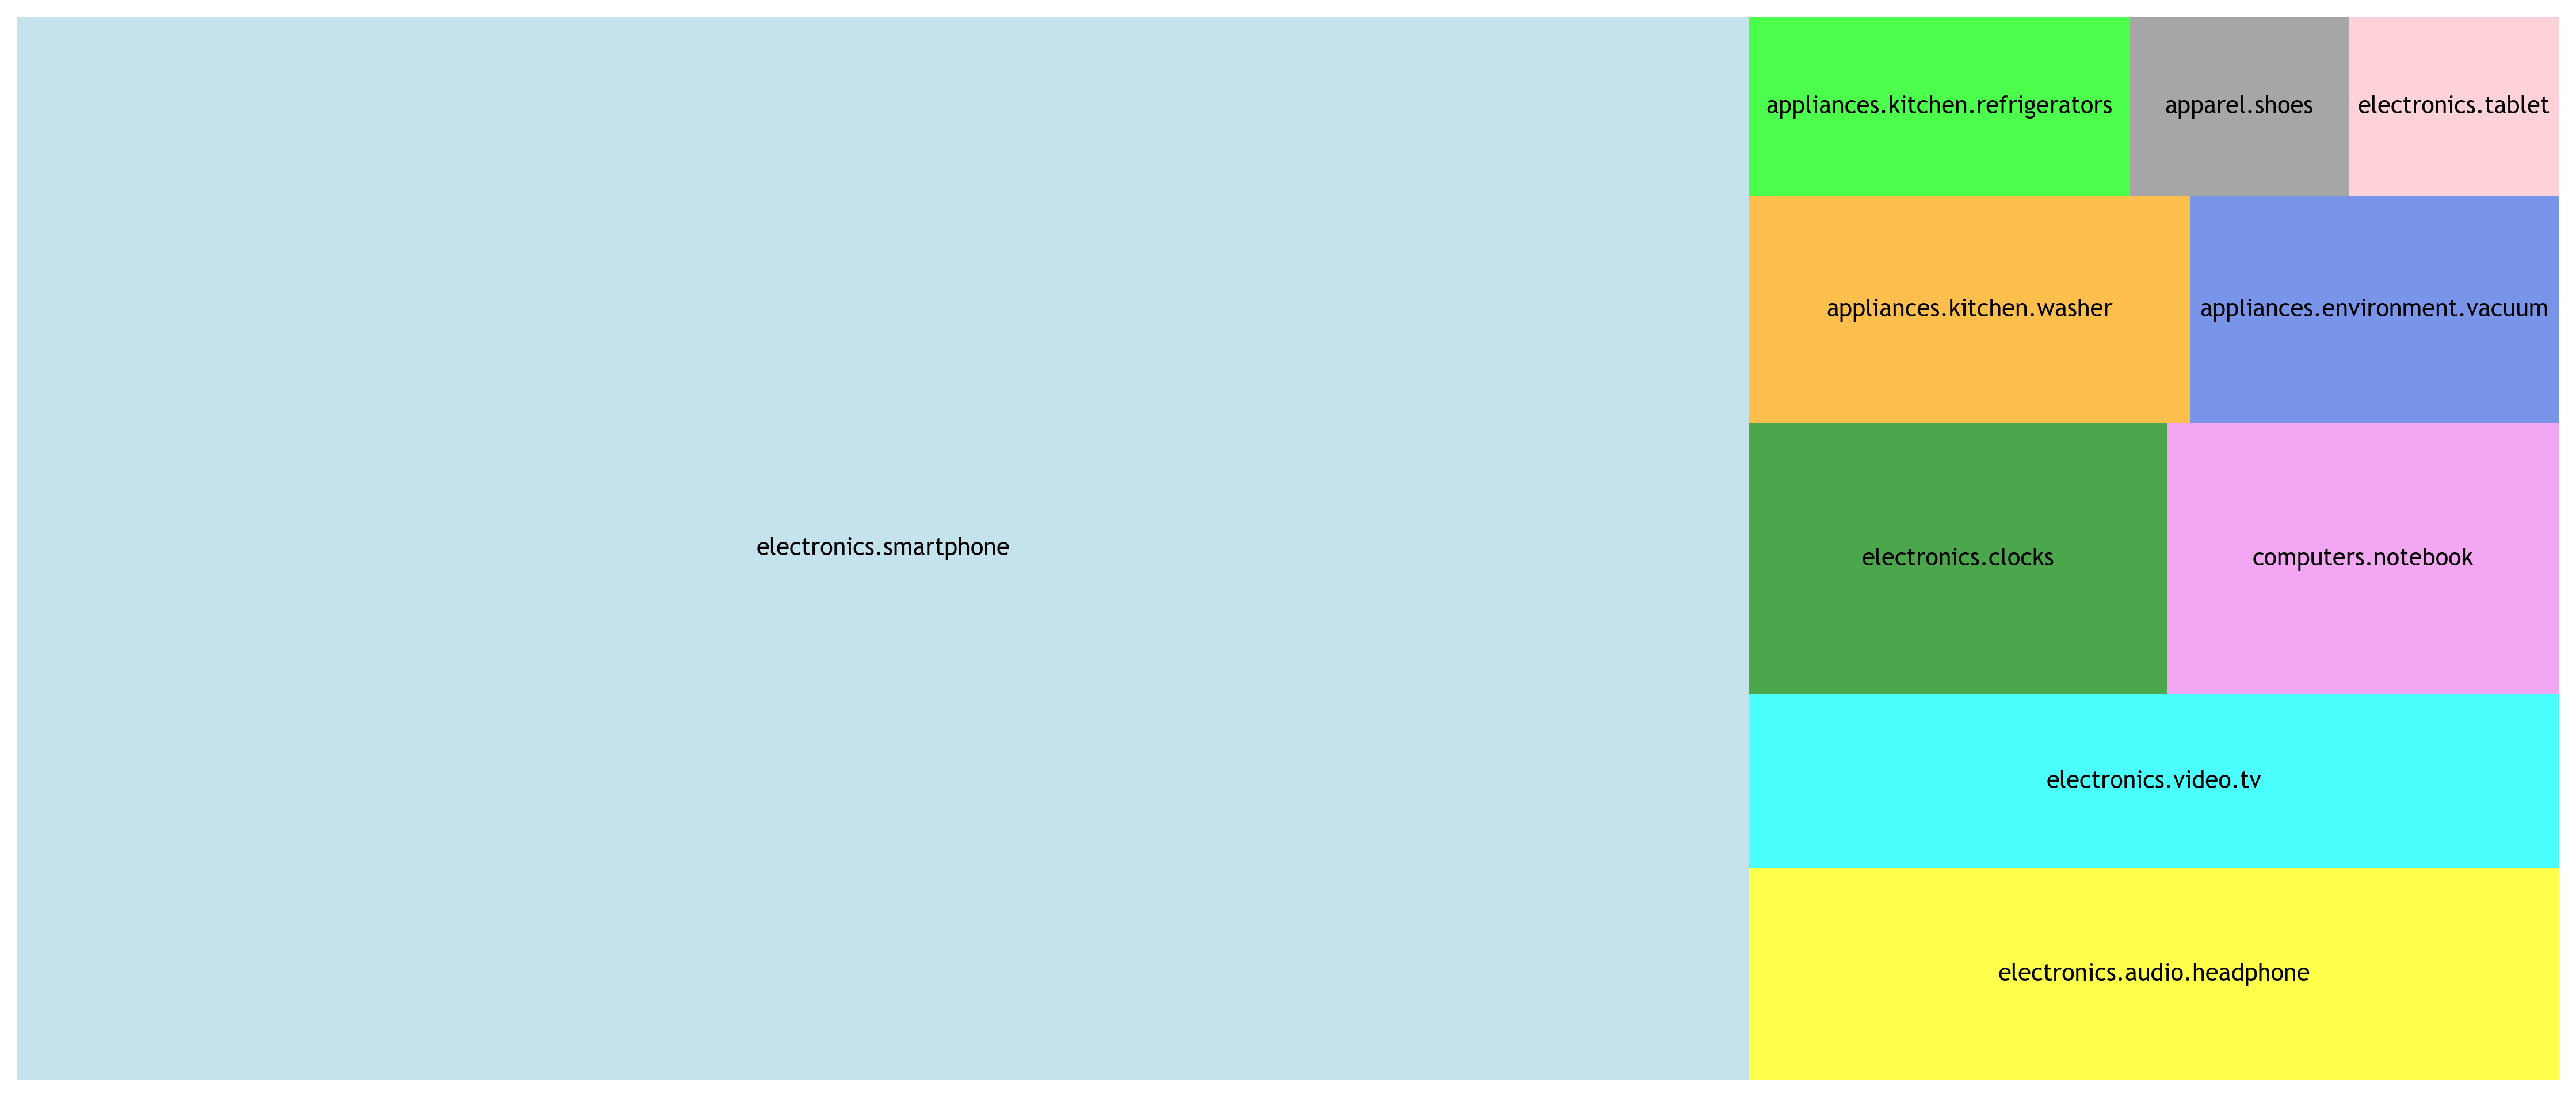

In [16]:
top_category_n = 10
plt.figure(figsize = (19, 8), dpi = 300)
top_category = balanced_df.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, 
              color=["lightblue", "yellow","cyan","green", "violet", "orange","royalblue", "lime","grey", "pink"], alpha=.7  )
plt.axis('off')
plt.show()

#### *What items do visitors purchase?* 

In [17]:
purchase = balanced_df.loc[balanced_df['event_type'] == 'purchase']
purchase.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
162,2019-10-01 00:02:14 UTC,purchase,1004856,2053013555631882655,electronics.smartphone,samsung,130.76,543272936,8187d148-3c41-46d4-b0c0-9c08cd9dc564
308,2019-10-01 00:04:37 UTC,purchase,1002532,2053013555631882655,electronics.smartphone,apple,642.69,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68
442,2019-10-01 00:07:07 UTC,purchase,13800054,2053013557418656265,furniture.bathroom.toilet,santeri,54.42,555332717,1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f
574,2019-10-01 00:09:26 UTC,purchase,4804055,2053013554658804075,electronics.audio.headphone,apple,189.91,524601178,2af9b570-0942-4dcd-8f25-4d84fba82553
603,2019-10-01 00:09:54 UTC,purchase,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,551377651,3c80f0d6-e9ec-4181-8c5c-837a30be2d68


#### *Which categories are users most interested in?*

In [18]:
#user defined functions
def extract_categorycode(input_text,level=0):
    '''
     this function splits category code and returns the first part.
    '''
    output_text=input_text.split('.')[level]
    return output_text

In [19]:
#splitting the category text into 2 pieces as category and subcategory
balanced_df['category']=balanced_df['category_code'].apply(extract_categorycode,level=0)
balanced_df['subcategory']=balanced_df['category_code'].apply(extract_categorycode,level=1)

In [20]:
#creating a summary table that contains an outline of categories and activities
category_summary_table=balanced_df.groupby(by=['category']).agg(
    number_of_views=('category','count'), number_of_users=('user_id',lambda x: x.nunique()), 
    number_of_sessions=('user_session',pd.Series.nunique)).reset_index()


sales_filter=balanced_df['event_type']=='purchase'
category_sales_summary_table=balanced_df.loc[sales_filter].groupby(by=['category']).agg(
    number_of_purchase=('category','count'), amount_of_purchase=('price','sum'),
    average_purchase_amount=('price','mean'), number_of_sessions_with_purchase=('user_session',pd.Series.nunique),
    number_of_shoppers=('user_id',lambda x: x.nunique())).reset_index()
                                                                                    
                                                                                                                             
category_summary_table=pd.merge(left=category_summary_table,
                               right=category_sales_summary_table,
                               left_on='category',
                               right_on='category',
                               how='left')

category_summary_table['conversion_rate']=category_summary_table['number_of_purchase']/category_summary_table['number_of_sessions']

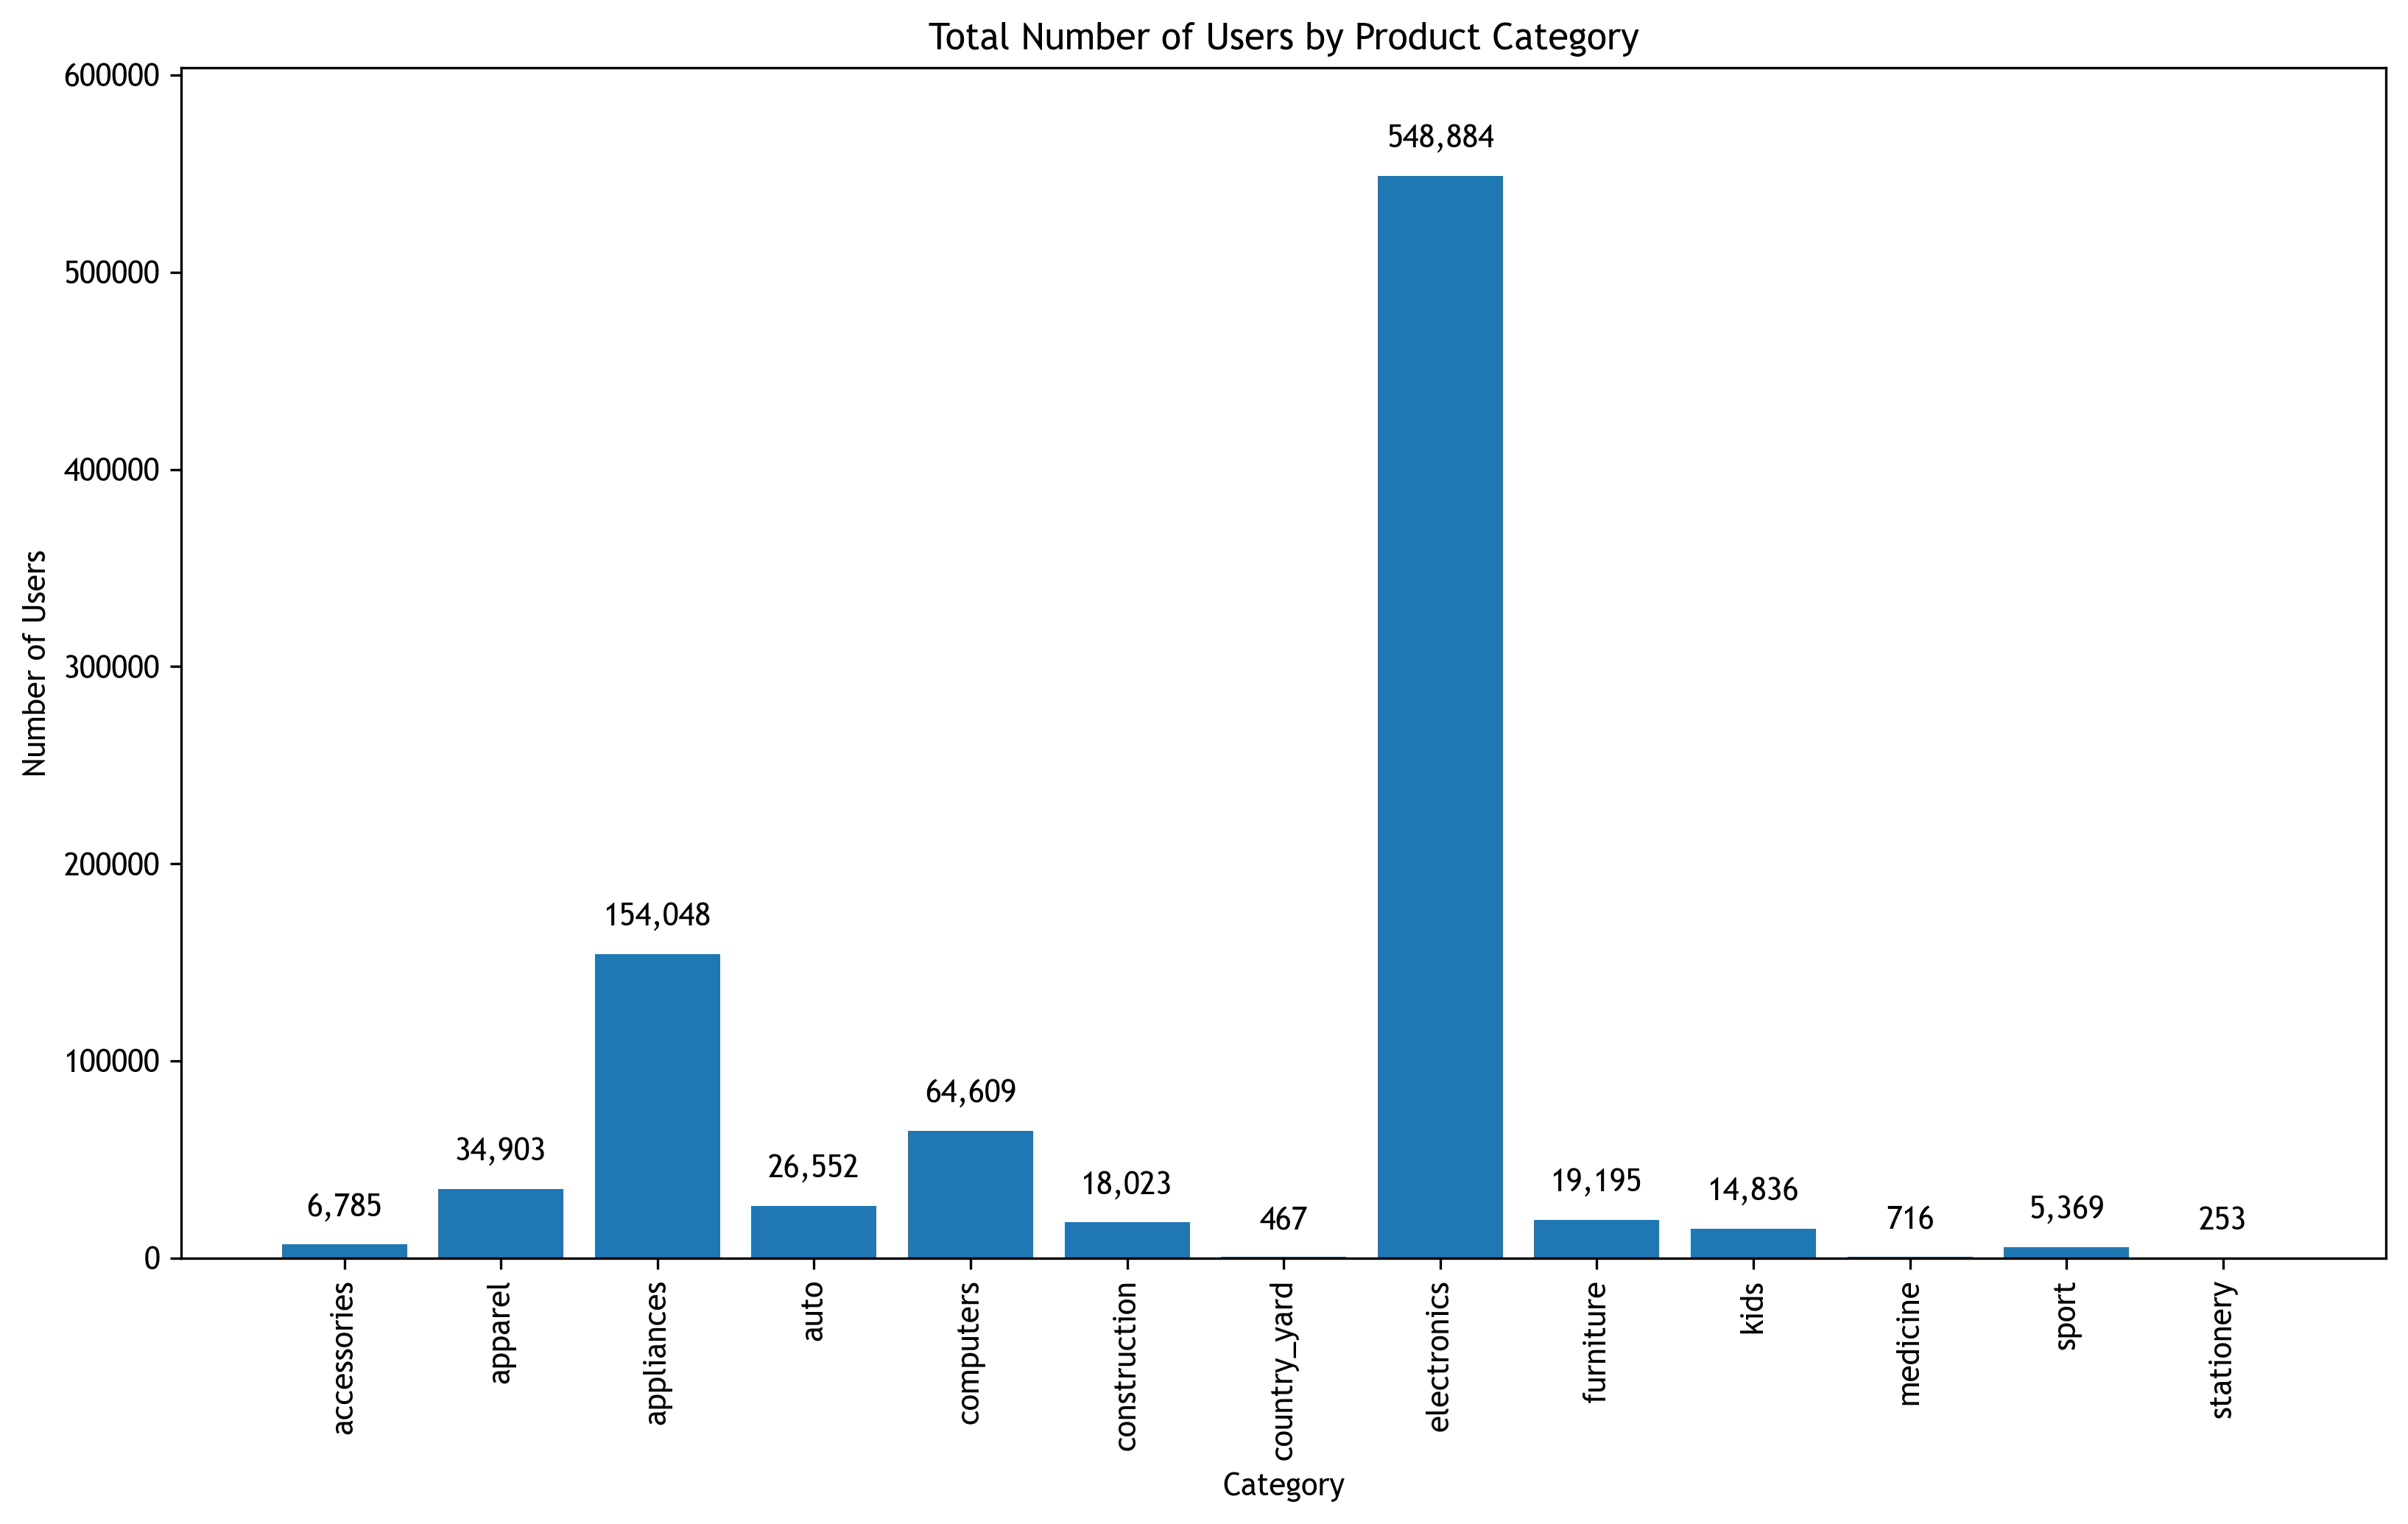

In [21]:
plt.figure(figsize=(11, 7), dpi=300)
bars = plt.bar(category_summary_table['category'], category_summary_table['number_of_users'])

# Annotate the bars with the number of users
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2,  # x position
             bar.get_height() + (0.02 * category_summary_table['number_of_users'].max()),  # y position
             format(bar.get_height(), ',.0f'),  # text
             ha='center', va='bottom')

plt.title('Total Number of Users by Product Category')
plt.xlabel('Category')
plt.ylabel('Number of Users')
plt.ylim(0, category_summary_table['number_of_users'].max() * 1.1)
plt.xticks(rotation=90)  # Make the tick labels of the x-axis vertical
plt.tight_layout()
plt.show()


#### *What brands do the visitors buy?*

In [22]:
top_sellers = purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
top_sellers.head(20)

,count
brand,
samsung,171706
apple,142577
xiaomi,46595
huawei,23294
oppo,10891
lg,7831
acer,6882
elenberg,5435
indesit,5023


<Figure size 2400x1500 with 0 Axes>

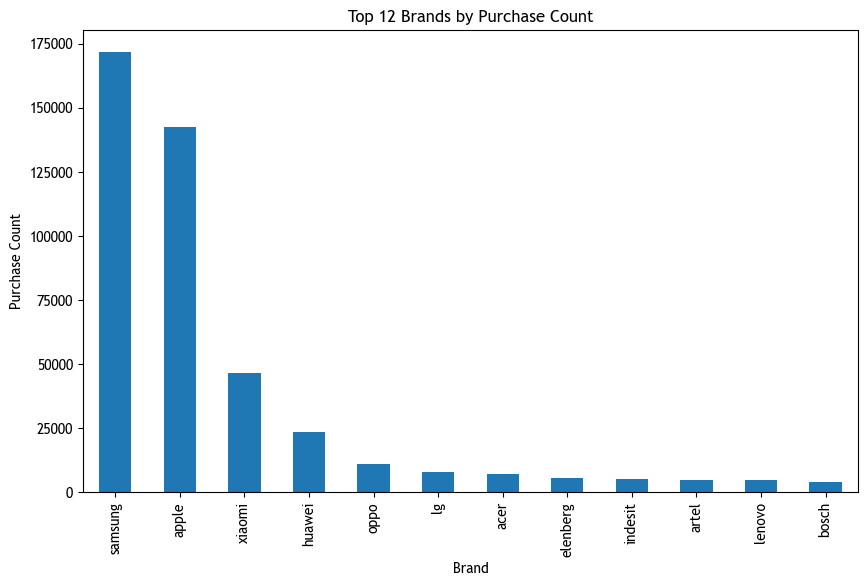

In [23]:
plt.figure(figsize = (8, 5), dpi = 300)
top_12_sellers = top_sellers.head(12)
top_12_sellers.plot(kind='bar', legend=False, figsize=(10,6))
plt.title('Top 12 Brands by Purchase Count')
plt.ylabel('Purchase Count')
plt.xlabel('Brand')
plt.show()

#### *What is the price range of products?*

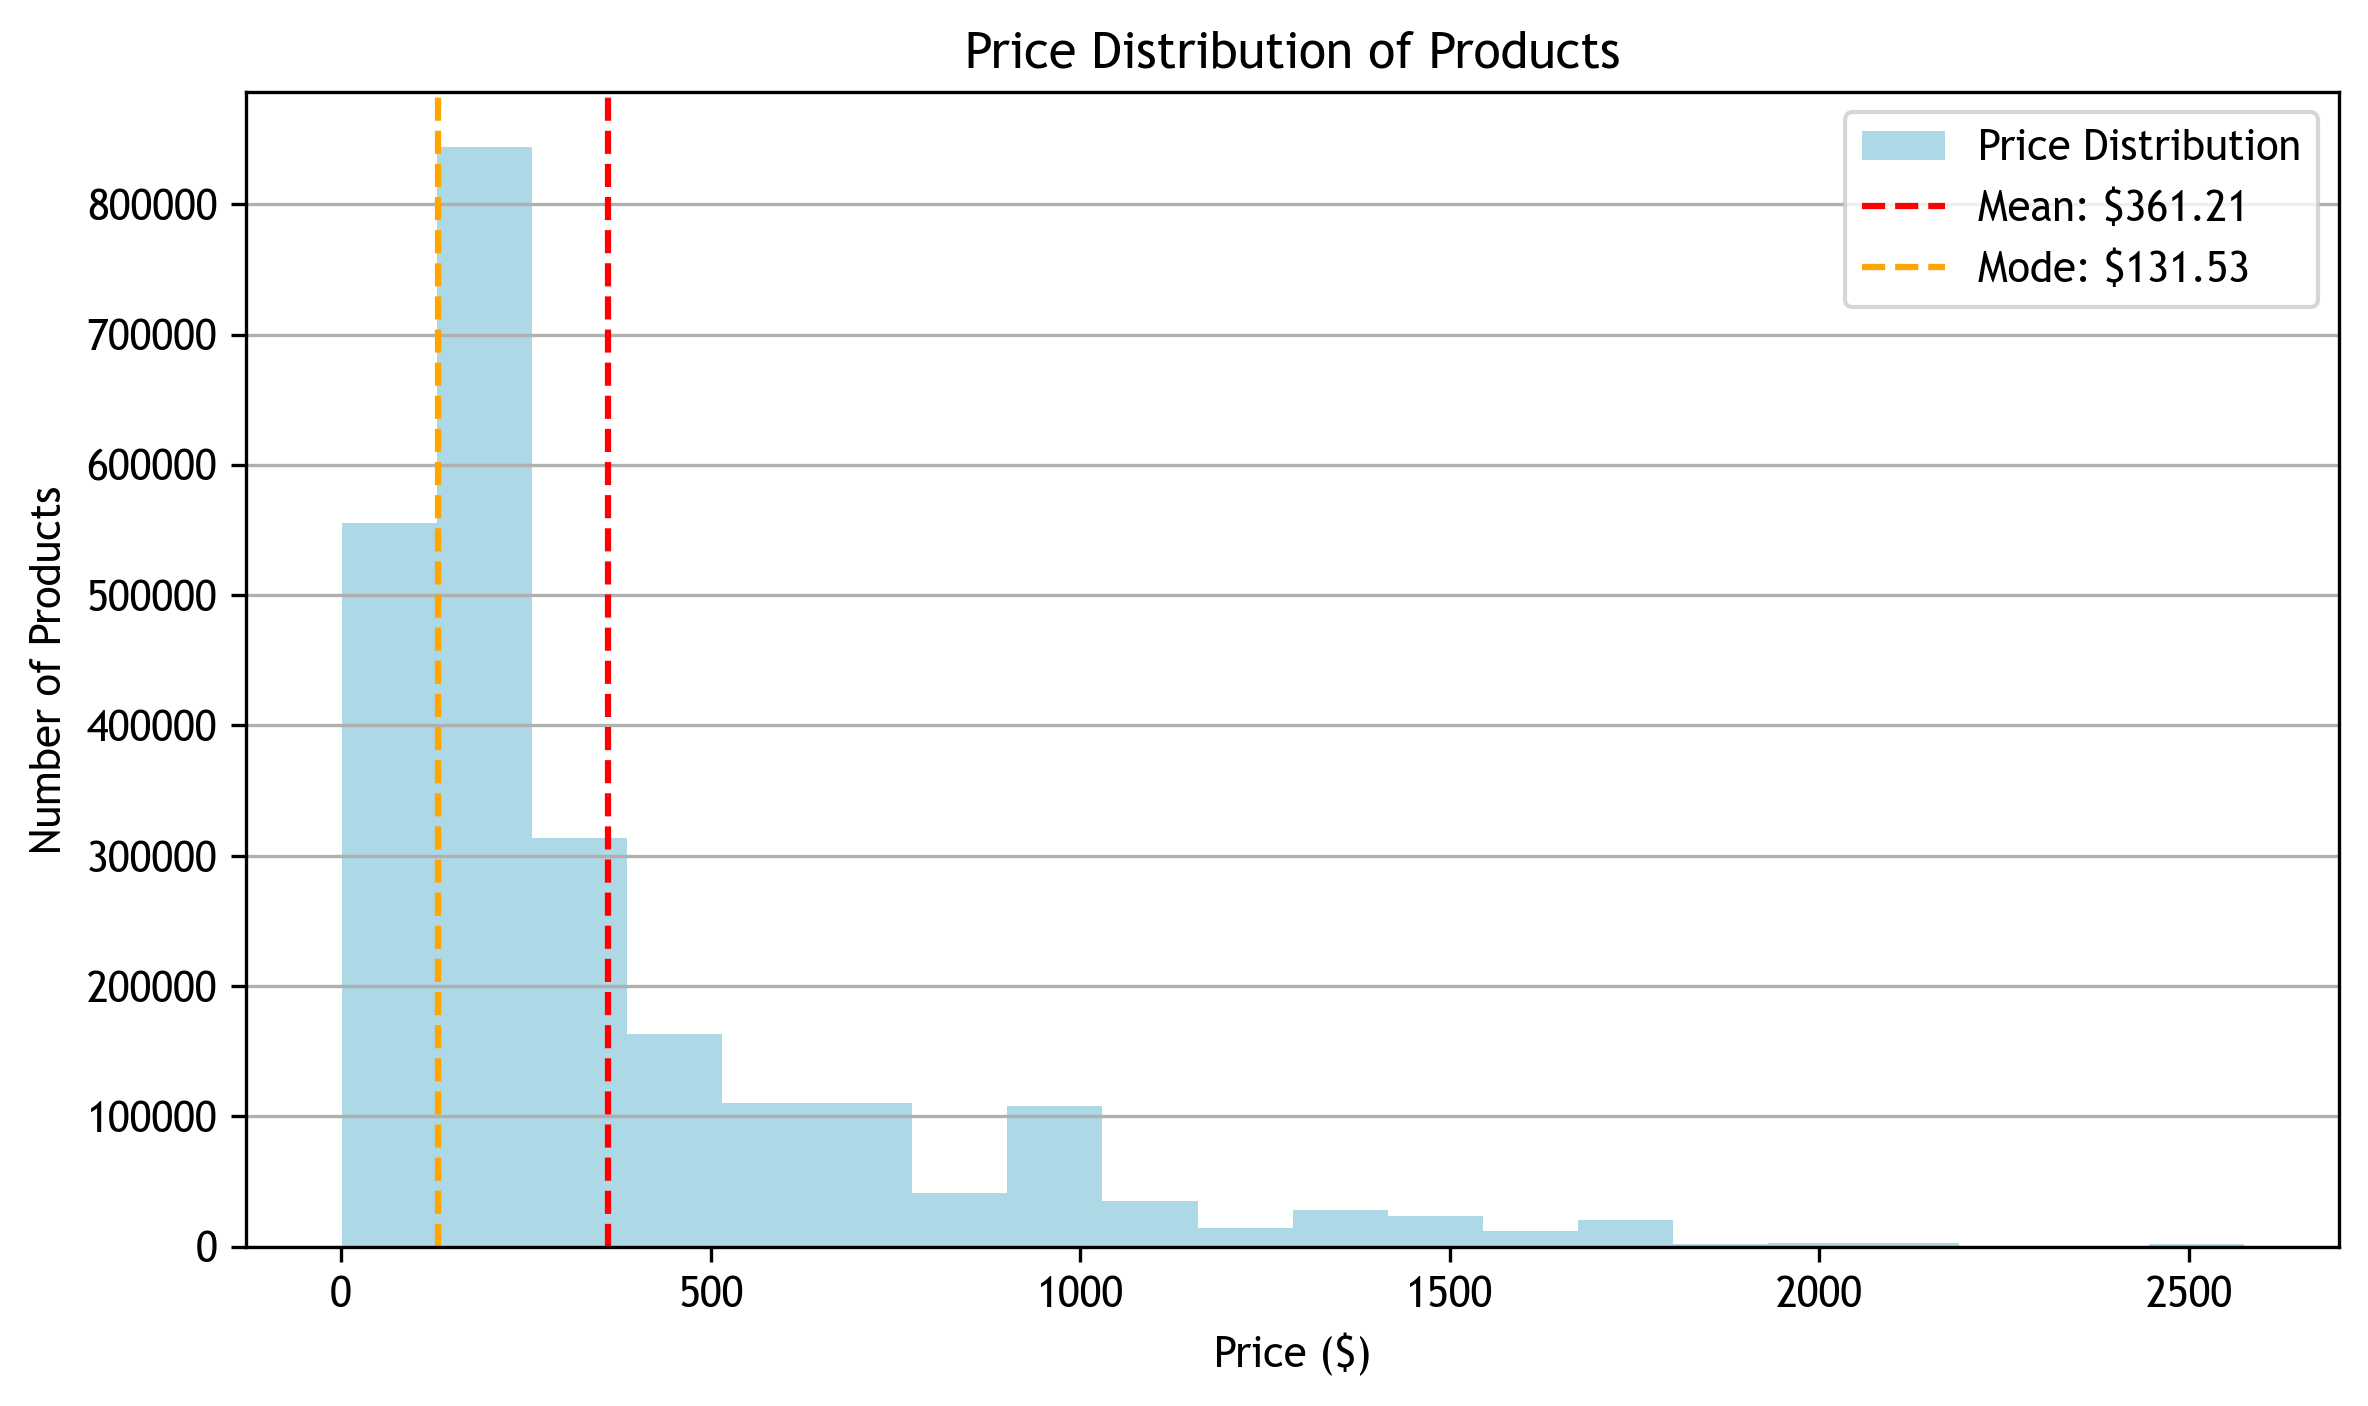

In [24]:
import numpy as np

# Plot the histogram of price
plt.figure(figsize=(9, 5), dpi=300)
plt.hist(balanced_df['price'], bins=20, color='lightblue', label='Price Distribution')  # Darker shade

# Compute mean and mode
mean_price = np.mean(balanced_df['price'])
mode_price = balanced_df['price'].mode().iloc[0]  # .mode() returns a Series, get the first mode

# Add dashed lines for mean and mode
plt.axvline(mean_price, color='r', linestyle='--', label=f'Mean: ${mean_price:.2f}')
plt.axvline(mode_price, color='orange', linestyle='--', label=f'Mode: ${mode_price:.2f}')

plt.title("Price Distribution of Products")
plt.xlabel("Price ($)")
plt.ylabel("Number of Products")
plt.grid(axis='y')
plt.legend()  # Display the legend
plt.show()


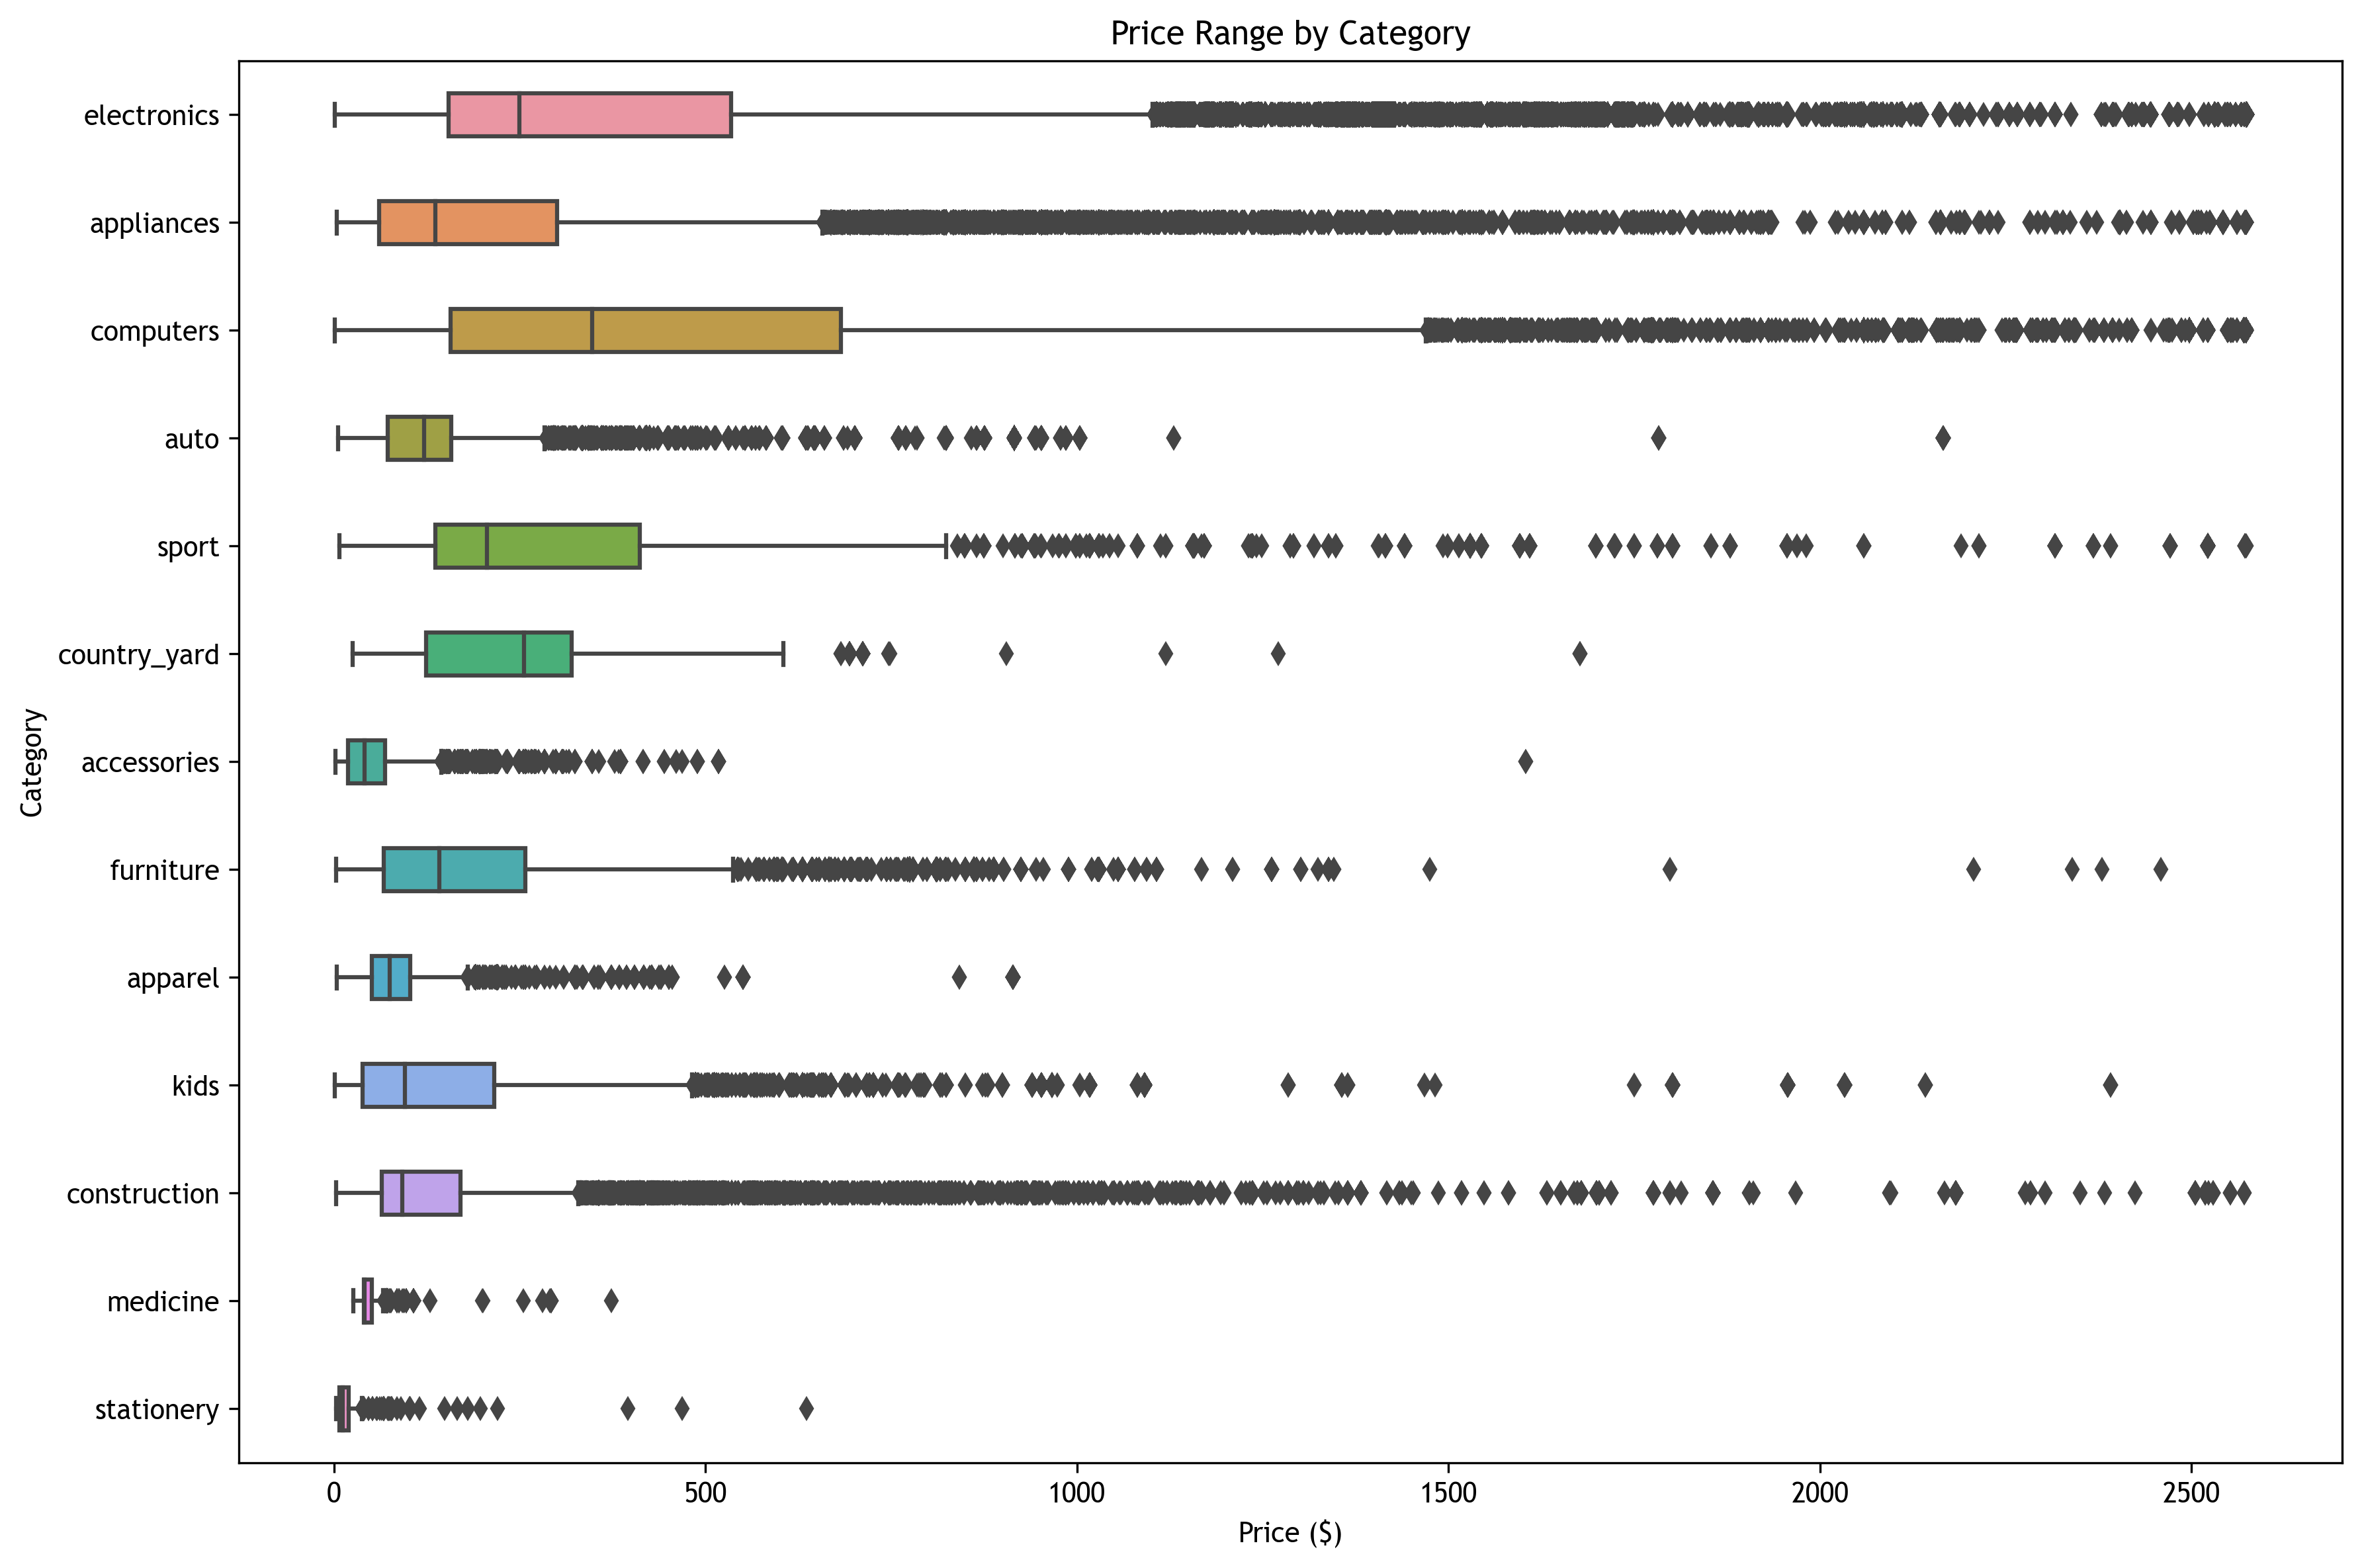

In [25]:
plt.figure(figsize=(12, 8), dpi=300)
sns.boxplot(data=balanced_df, y='category', x='price', width=0.4)  # Swap x and y, and reduce box width
plt.title('Price Range by Category')
plt.ylabel('Category')
plt.xlabel('Price ($)')
plt.tight_layout()
plt.show()


### Feature Engineering 

Some new features are introduced into the training data set:

- category
- sub-category
- event_weekday: weekday of the event
- activity_count: number of events in that session
- is_purchased: whether the item added to the cart is purchased

Thus, the training data set contains every non-duplicated cart transaction. These features along with the original price and brand will be used to predict whether customers will eventually purchase the item in the cart.

In [26]:

df_targets = balanced_df.loc[balanced_df["event_type"].isin(["cart", "purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase", 1, 0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets.dropna(how='any', inplace=True)
df_targets["category"] = df_targets["category_code"].str.split(".",expand=True)[0].astype('category')
df_targets["sub-category"] = df_targets["category_code"].str.split(".",expand=True)[1].astype('category')

In [27]:
cart_purchase_users = balanced_df.loc[balanced_df["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = balanced_df.loc[balanced_df['user_id'].isin(cart_purchase_users['user_id'])]

In [28]:
# Count the user activity in the session
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})

In [29]:
del data_slice # free memory

In [30]:
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)
df_targets.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session,category,subcategory,is_purchased,event_weekday,sub-category,activity_count
0,2019-10-01 00:09:33 UTC,cart,1002524,2053013555631882655,electronics.smartphone,apple,515.67,524325294,0b74a829-f9d7-4654-b5b0-35bc9822c238,electronics,smartphone,1,1,smartphone,2
1,2019-10-01 00:11:00 UTC,cart,4804056,2053013554658804075,electronics.audio.headphone,apple,161.98,533624186,e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683,electronics,audio,0,1,audio,2
2,2019-10-01 02:17:59 UTC,cart,1004833,2053013555631882655,electronics.smartphone,samsung,174.76,536415846,685b5b42-f597-4a69-ab4c-ef96a30bc454,electronics,smartphone,0,1,smartphone,3
3,2019-10-01 02:19:36 UTC,cart,1005003,2053013555631882655,electronics.smartphone,huawei,258.21,513632293,f2cc68f7-39d1-4a50-9dcf-f2a0921bdfda,electronics,smartphone,1,1,smartphone,5
4,2019-10-01 02:19:43 UTC,cart,1004750,2053013555631882655,electronics.smartphone,samsung,197.43,555110488,ce885079-4d92-4fe6-92a3-377c5a2d8291,electronics,smartphone,1,1,smartphone,6


In [31]:
# Save dataset for model training
df_targets.to_csv('training_data.csv')

In [4]:
df_targets = pd.read_csv('training_data.csv')

In [5]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 546600 entries, 0 to 546599
Data columns (total 16 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Unnamed: 0      546600 non-null  int64  
 1   event_time      546600 non-null  object 
 2   event_type      546600 non-null  object 
 3   product_id      546600 non-null  int64  
 4   category_id     546600 non-null  int64  
 5   category_code   546600 non-null  object 
 6   brand           546600 non-null  object 
 7   price           546600 non-null  float64
 8   user_id         546600 non-null  int64  
 9   user_session    546600 non-null  object 
 10  category        546600 non-null  object 
 11  subcategory     546600 non-null  object 
 12  is_purchased    546600 non-null  int64  
 13  event_weekday   546600 non-null  int64  
 14  sub-category    546600 non-null  object 
 15  activity_count  546600 non-null  int64  
dtypes: float64(1), int64(7), object(8)
memory usage: 66.7+ M

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.utils import resample
from sklearn import metrics

In [7]:
is_purcahase_set = df_targets[df_targets['is_purchased']== 1]
is_purcahase_set.shape[0]

273909

In [8]:
not_purcahase_set = df_targets[df_targets['is_purchased']== 0]
not_purcahase_set.shape[0]

272691

In [9]:
combined_data = pd.concat([is_purcahase_set, not_purcahase_set])
combined_data['is_purchased'].value_counts()

1    273909
0    272691
Name: is_purchased, dtype: int64

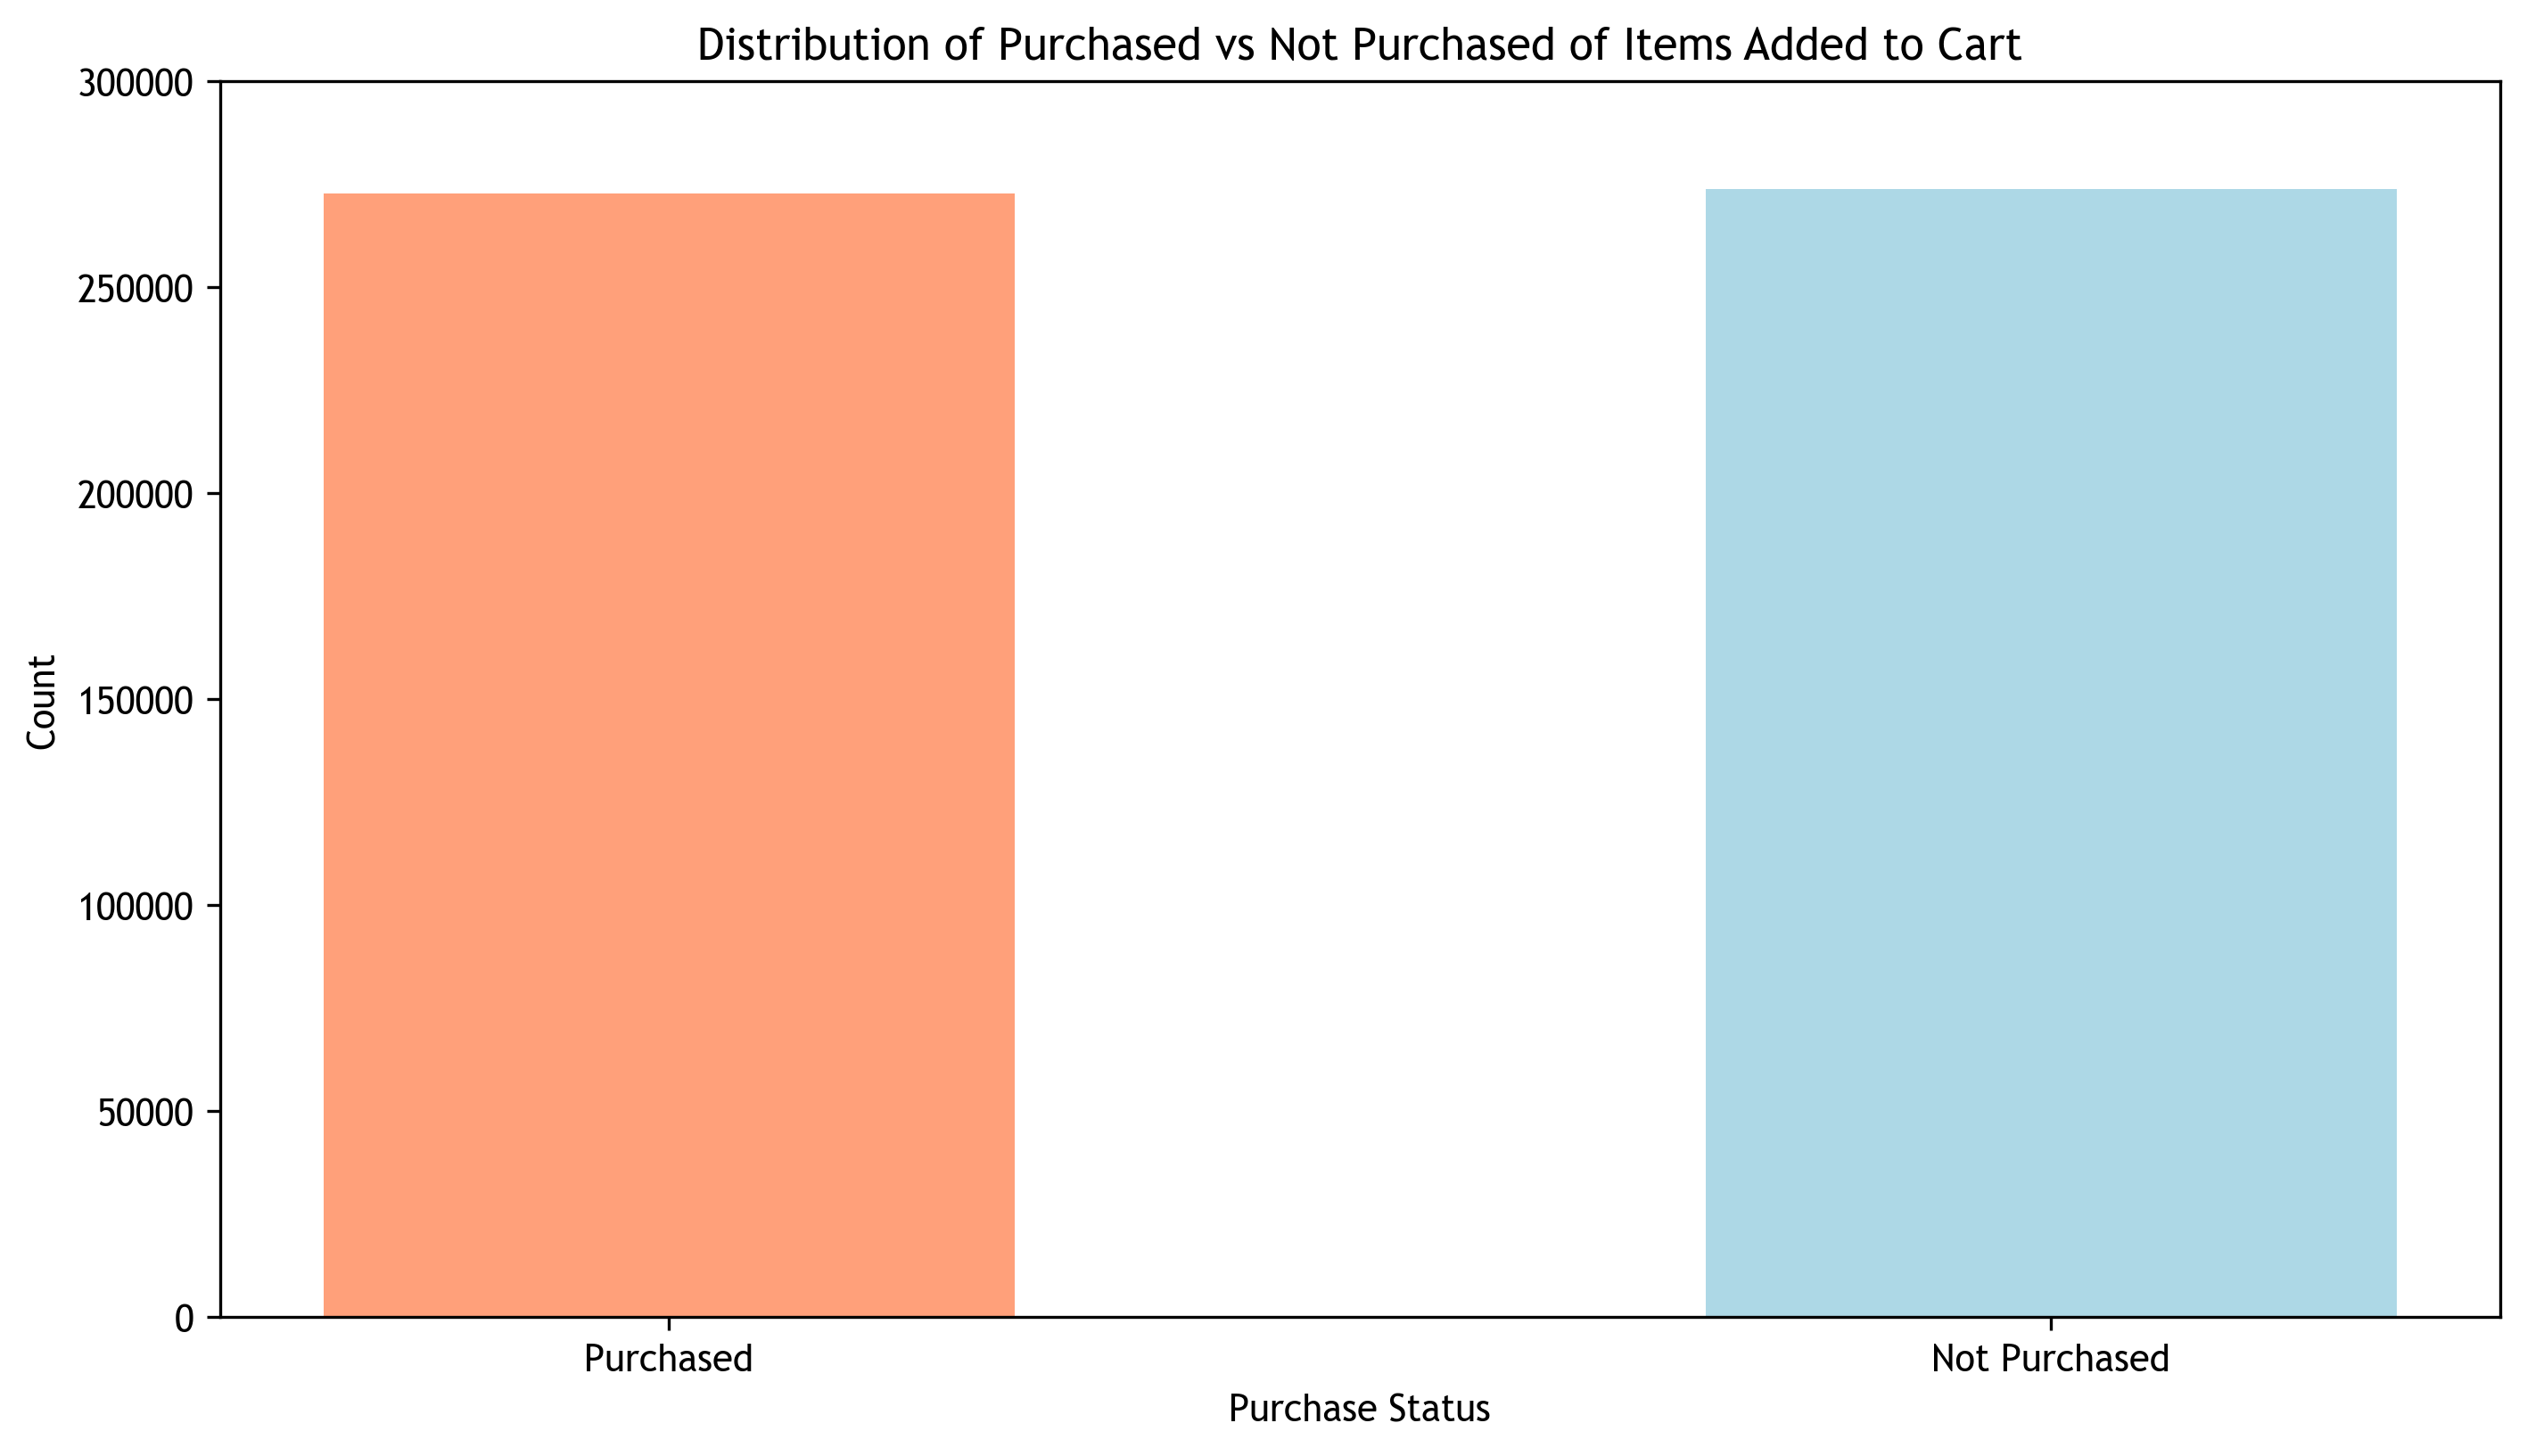

In [10]:
purchase_counts = combined_data['is_purchased'].value_counts()

# Plot the bar chart
plt.figure(figsize = (11, 6), dpi = 300)
plt.bar(purchase_counts.index, purchase_counts.values, width=0.5, color=['lightblue', 'lightsalmon'])  # Reduced width and lighter orange
plt.xticks(purchase_counts.index, ['Not Purchased', 'Purchased'])
plt.xlabel('Purchase Status')
plt.ylabel('Count')
plt.ylim(0, 300000)
plt.title('Distribution of Purchased vs Not Purchased of Items Added to Cart')
plt.show()

### Model Selection and Training

In [11]:
features = combined_data.loc[:,['brand', 'price', 'event_weekday', 'category', 'sub-category', 'activity_count']]

In [12]:
# Encode categorical variables
features.loc[:,'brand'] = LabelEncoder().fit_transform(combined_data.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(combined_data.loc[:,'event_weekday'].copy())
features.loc[:,'category'] = LabelEncoder().fit_transform(combined_data.loc[:,'category'].copy())
features.loc[:,'sub-category'] = LabelEncoder().fit_transform(combined_data.loc[:,'sub-category'].copy())

is_purchased = LabelEncoder().fit_transform(combined_data['is_purchased'])
features.head()

C:\Users\xclus\AppData\Local\Temp\ipykernel_6864\2886105241.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features.loc[:,'brand'] = LabelEncoder().fit_transform(combined_data.loc[:,'brand'].copy())
C:\Users\xclus\AppData\Local\Temp\ipykernel_6864\2886105241.py:4: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  features.loc[:,'category'] = LabelEncoder().fit_transform(combined_data.loc[:,'category'].copy())
C:\Users\xclus\AppData\Local\Temp\ipykernel_6864\2886105241.py:5: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt t

,brand,price,event_weekday,category,sub-category,activity_count
0,21,515.67,1,7,27,2
3,159,258.21,1,7,27,5
4,292,197.43,1,7,27,6
6,292,787.18,1,7,27,2
7,113,116.73,1,4,23,4


In [13]:
print(list(features.columns))

['brand', 'price', 'event_weekday', 'category', 'sub-category', 'activity_count']


In [14]:
#from sklearn.preprocessing import StandardScaler

# Instantiate the StandardScaler
#scaler = StandardScaler()

# Standardize the features
#standardized_features = scaler.fit_transform(features)

# Convert the standardized features back to a DataFrame
#standardized_features_df = pd.DataFrame(standardized_features, columns=features.columns)

#standardized_features_df.head()

In [15]:
# Split the dataset for training and testing
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 0)

In [16]:
X_train.shape, X_test.shape

((382620, 6), (163980, 6))

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(random_state=42)
}

# Initialize the dictionary to store the accuracy scores
model_accuracies = {}

# Train and evaluate each model
for name, model in models.items():
    #print(f"Training {name}...")
    model.fit(X_train, y_train)
    
    #print(f"Evaluating {name}...")
    y_pred = model.predict(X_test)
    
    # Print classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("-" * 60)  # separator
    
    # Add accuracy score to the dictionary
    model_accuracies[name] = accuracy_score(y_test, y_pred)

print("All models have been trained and evaluated!")


Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           0       0.60      0.77      0.68     81816
           1       0.68      0.48      0.57     82164

    accuracy                           0.63    163980
   macro avg       0.64      0.63      0.62    163980
weighted avg       0.64      0.63      0.62    163980

------------------------------------------------------------
Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.76      0.65      0.70     81816
           1       0.70      0.79      0.74     82164

    accuracy                           0.72    163980
   macro avg       0.73      0.72      0.72    163980
weighted avg       0.73      0.72      0.72    163980

------------------------------------------------------------
Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.80      0.63      0

### Model Evaluation

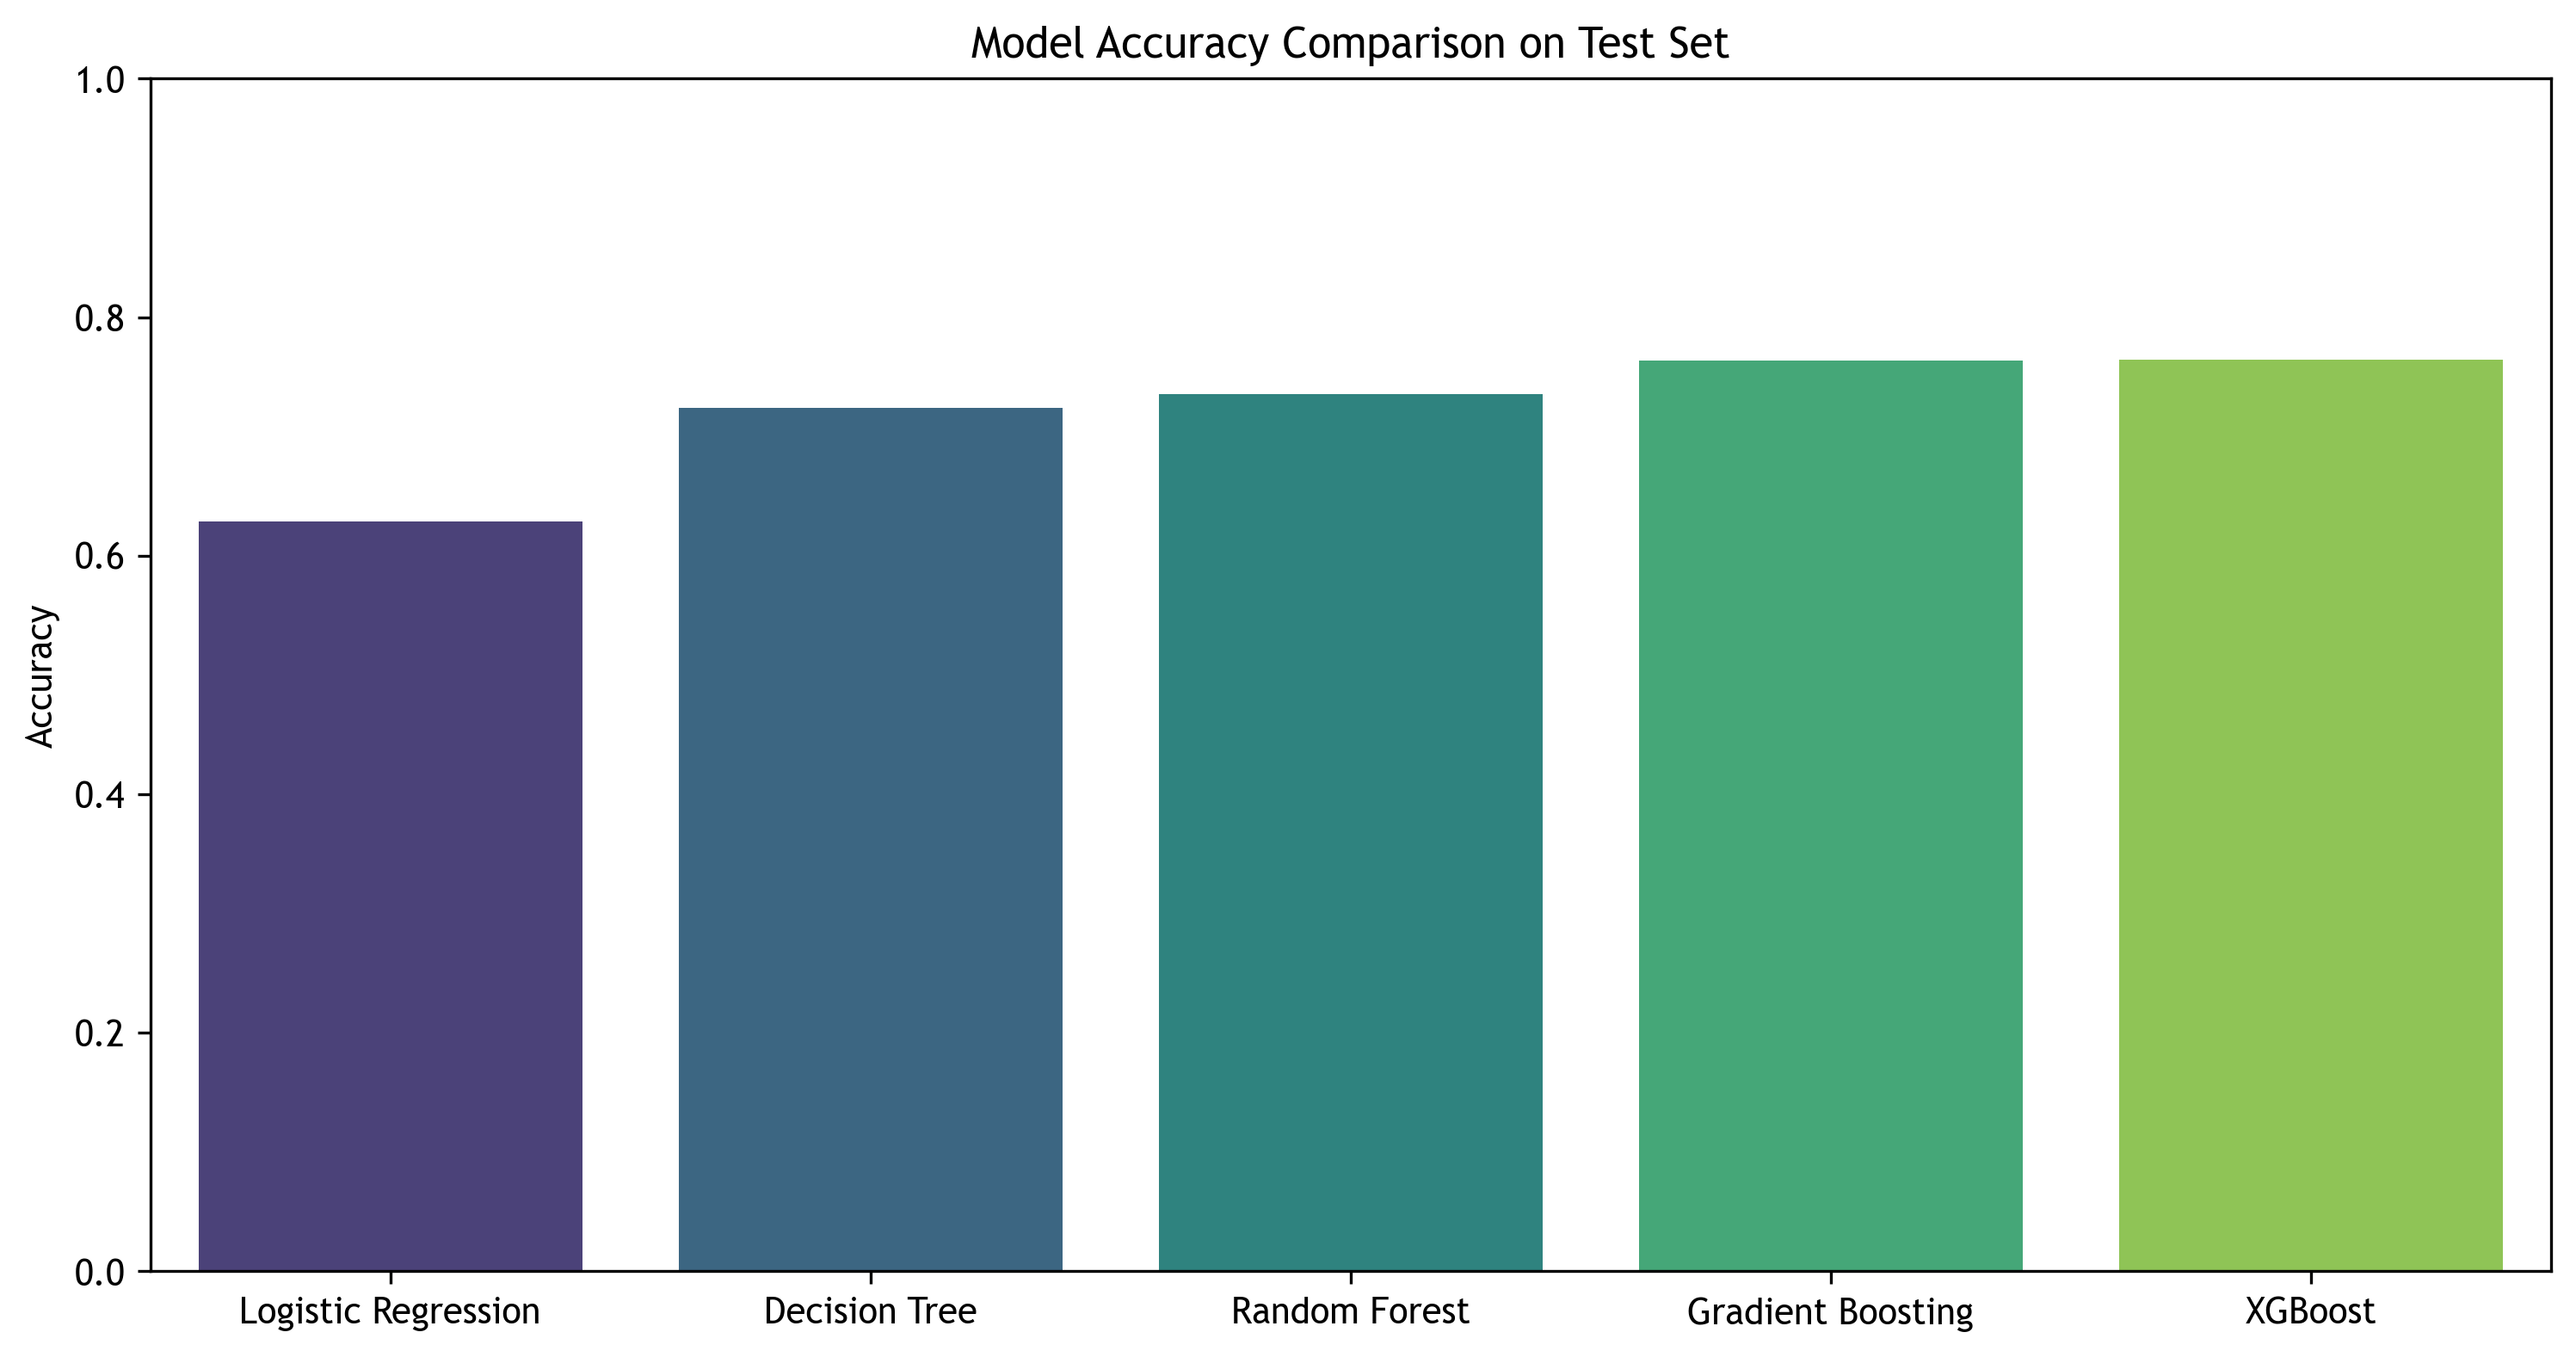

In [18]:
# Visualize model accuracies for comparison
plt.figure(figsize=(12, 6), dpi = 300)
sns.barplot(x=list(model_accuracies.keys()), y=list(model_accuracies.values()), palette="viridis")
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison on Test Set')
plt.show()

### Results and Insights

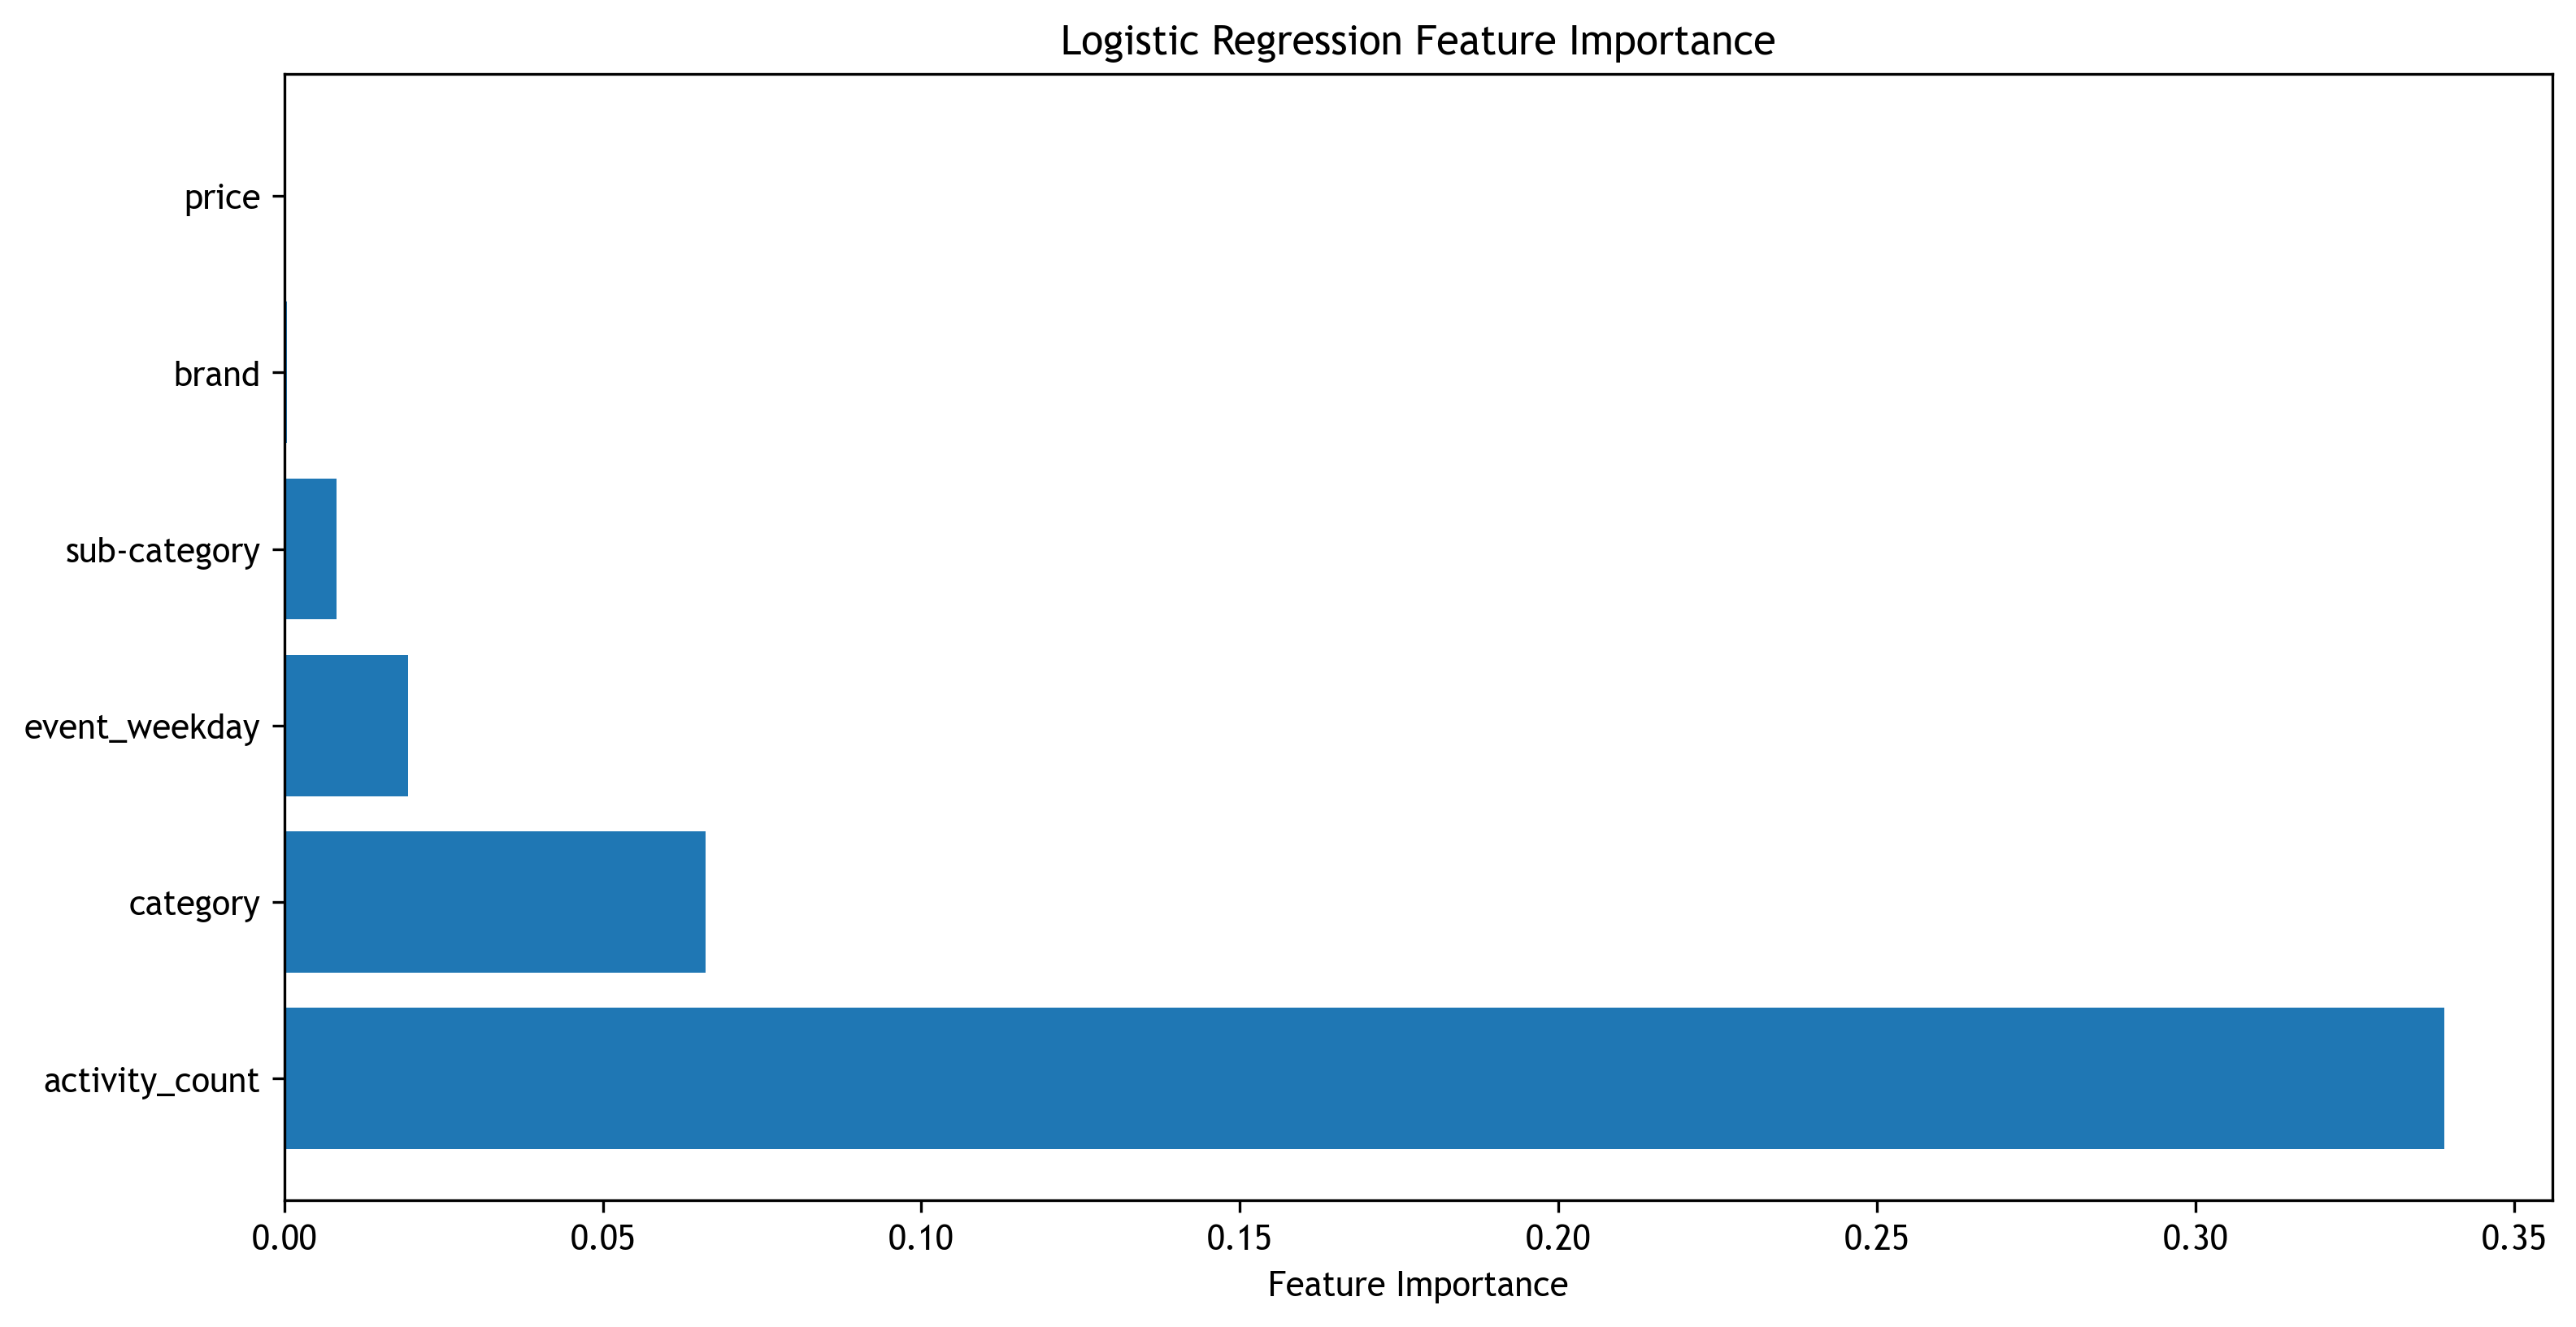

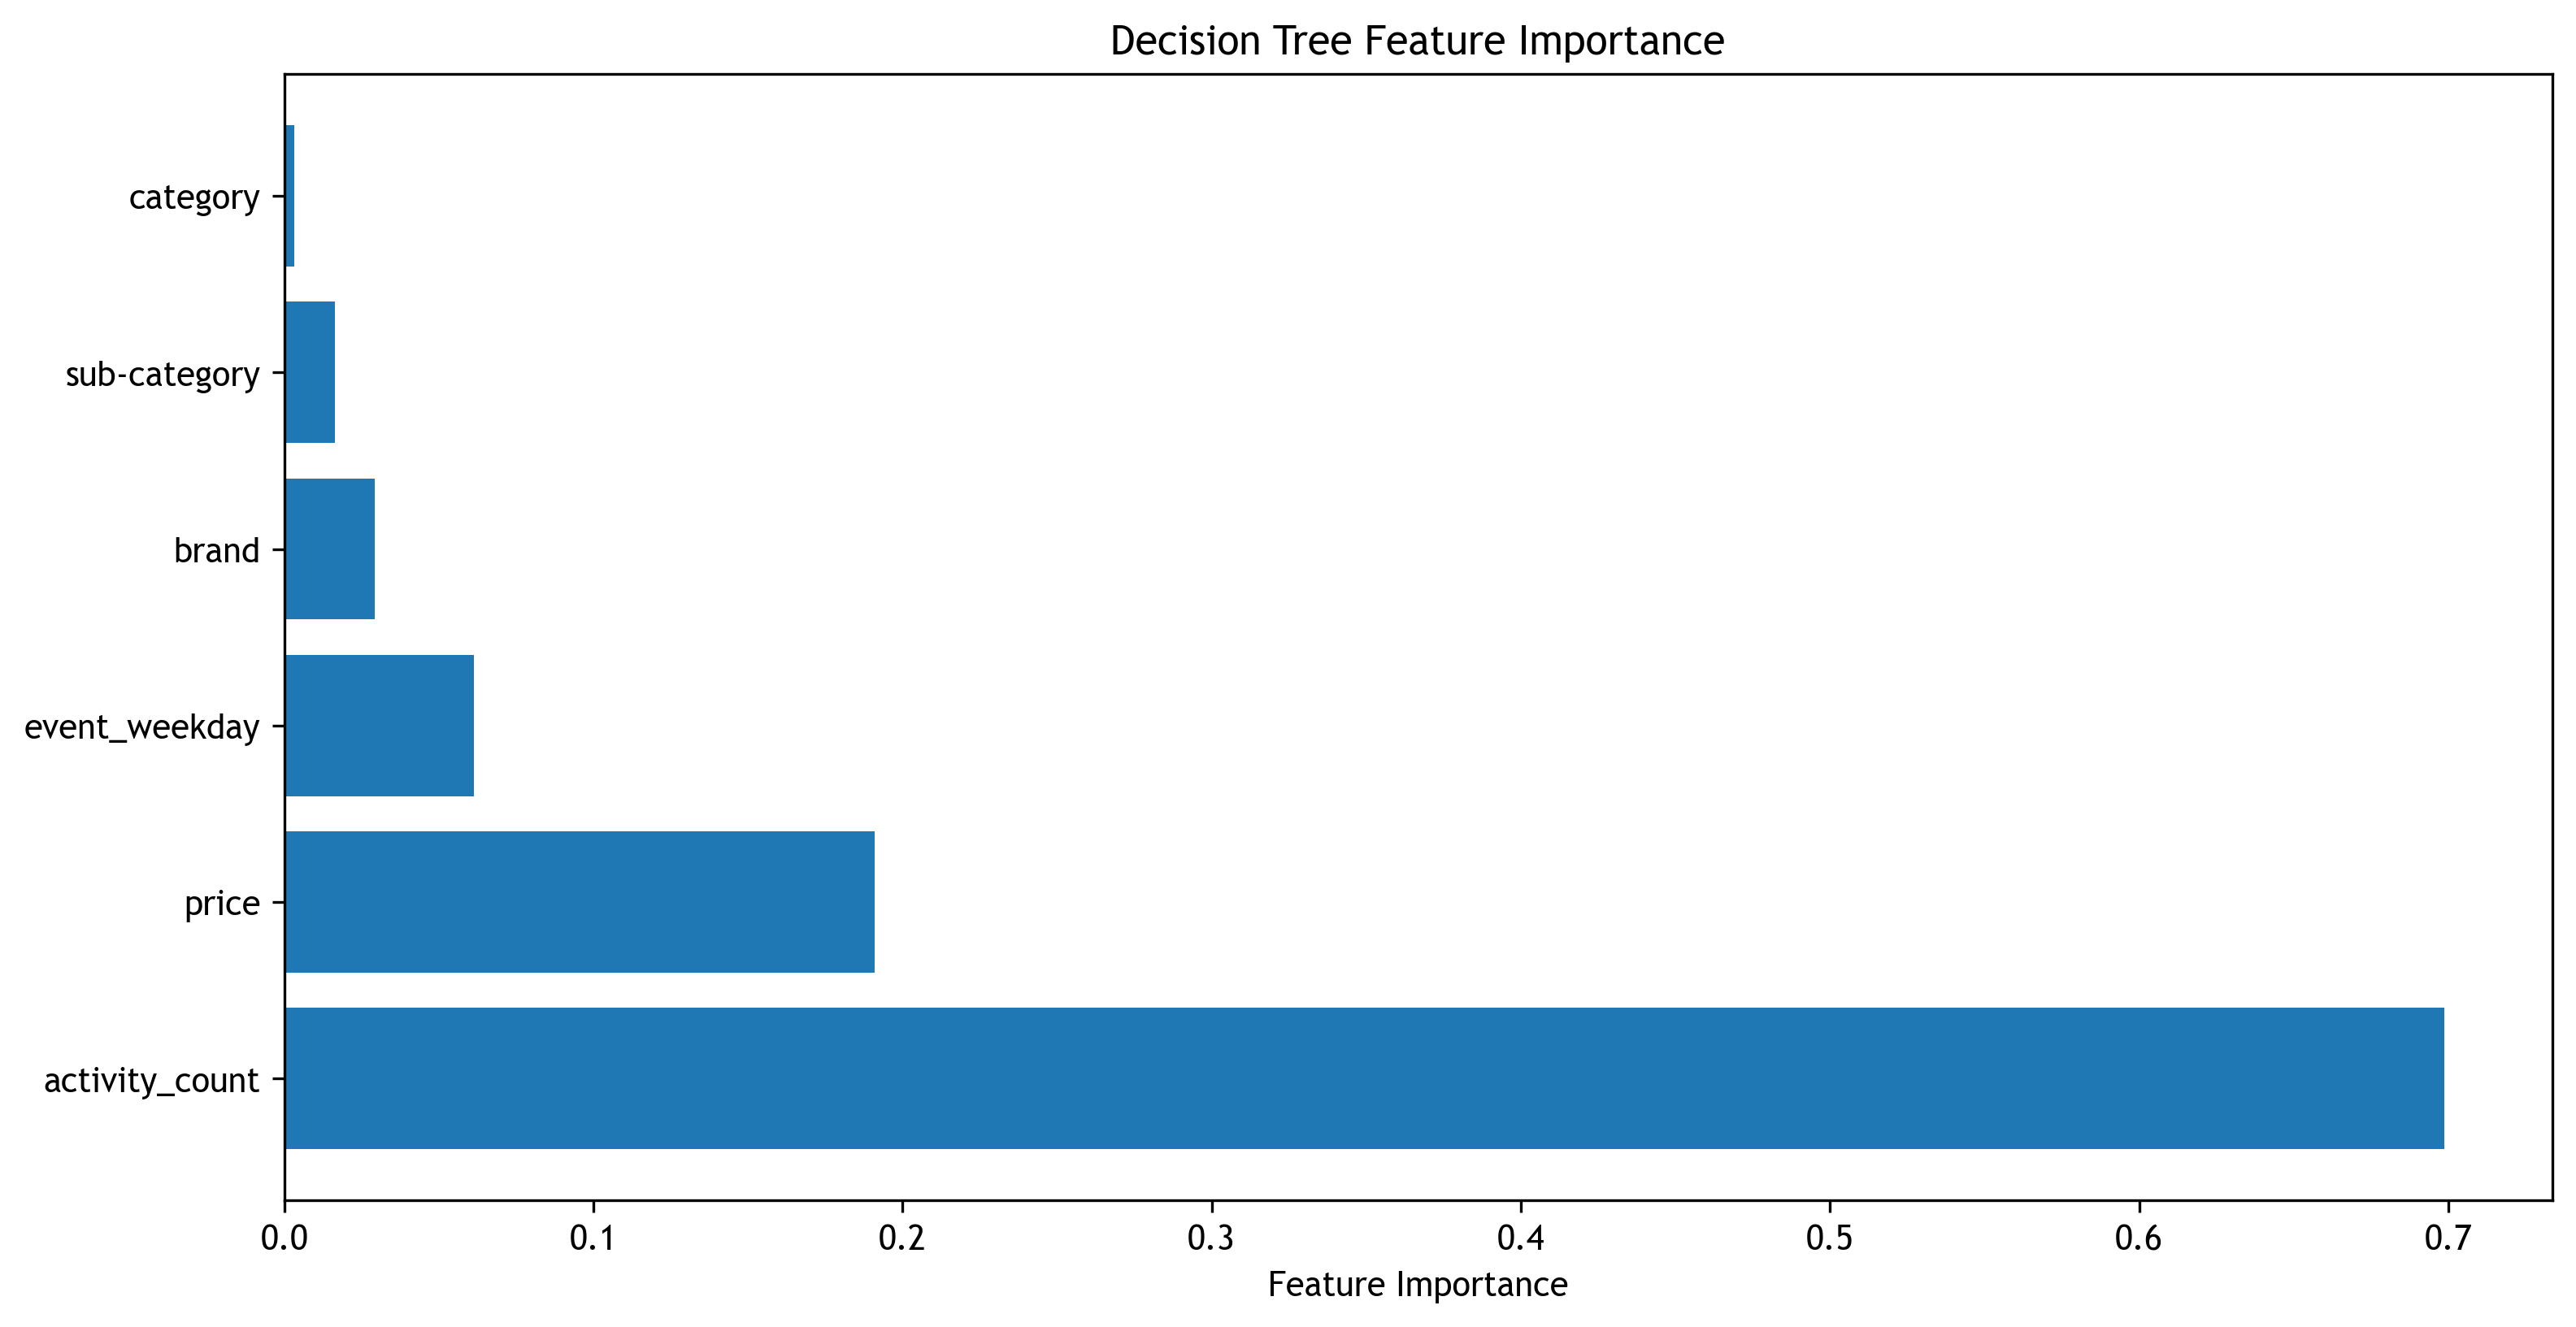

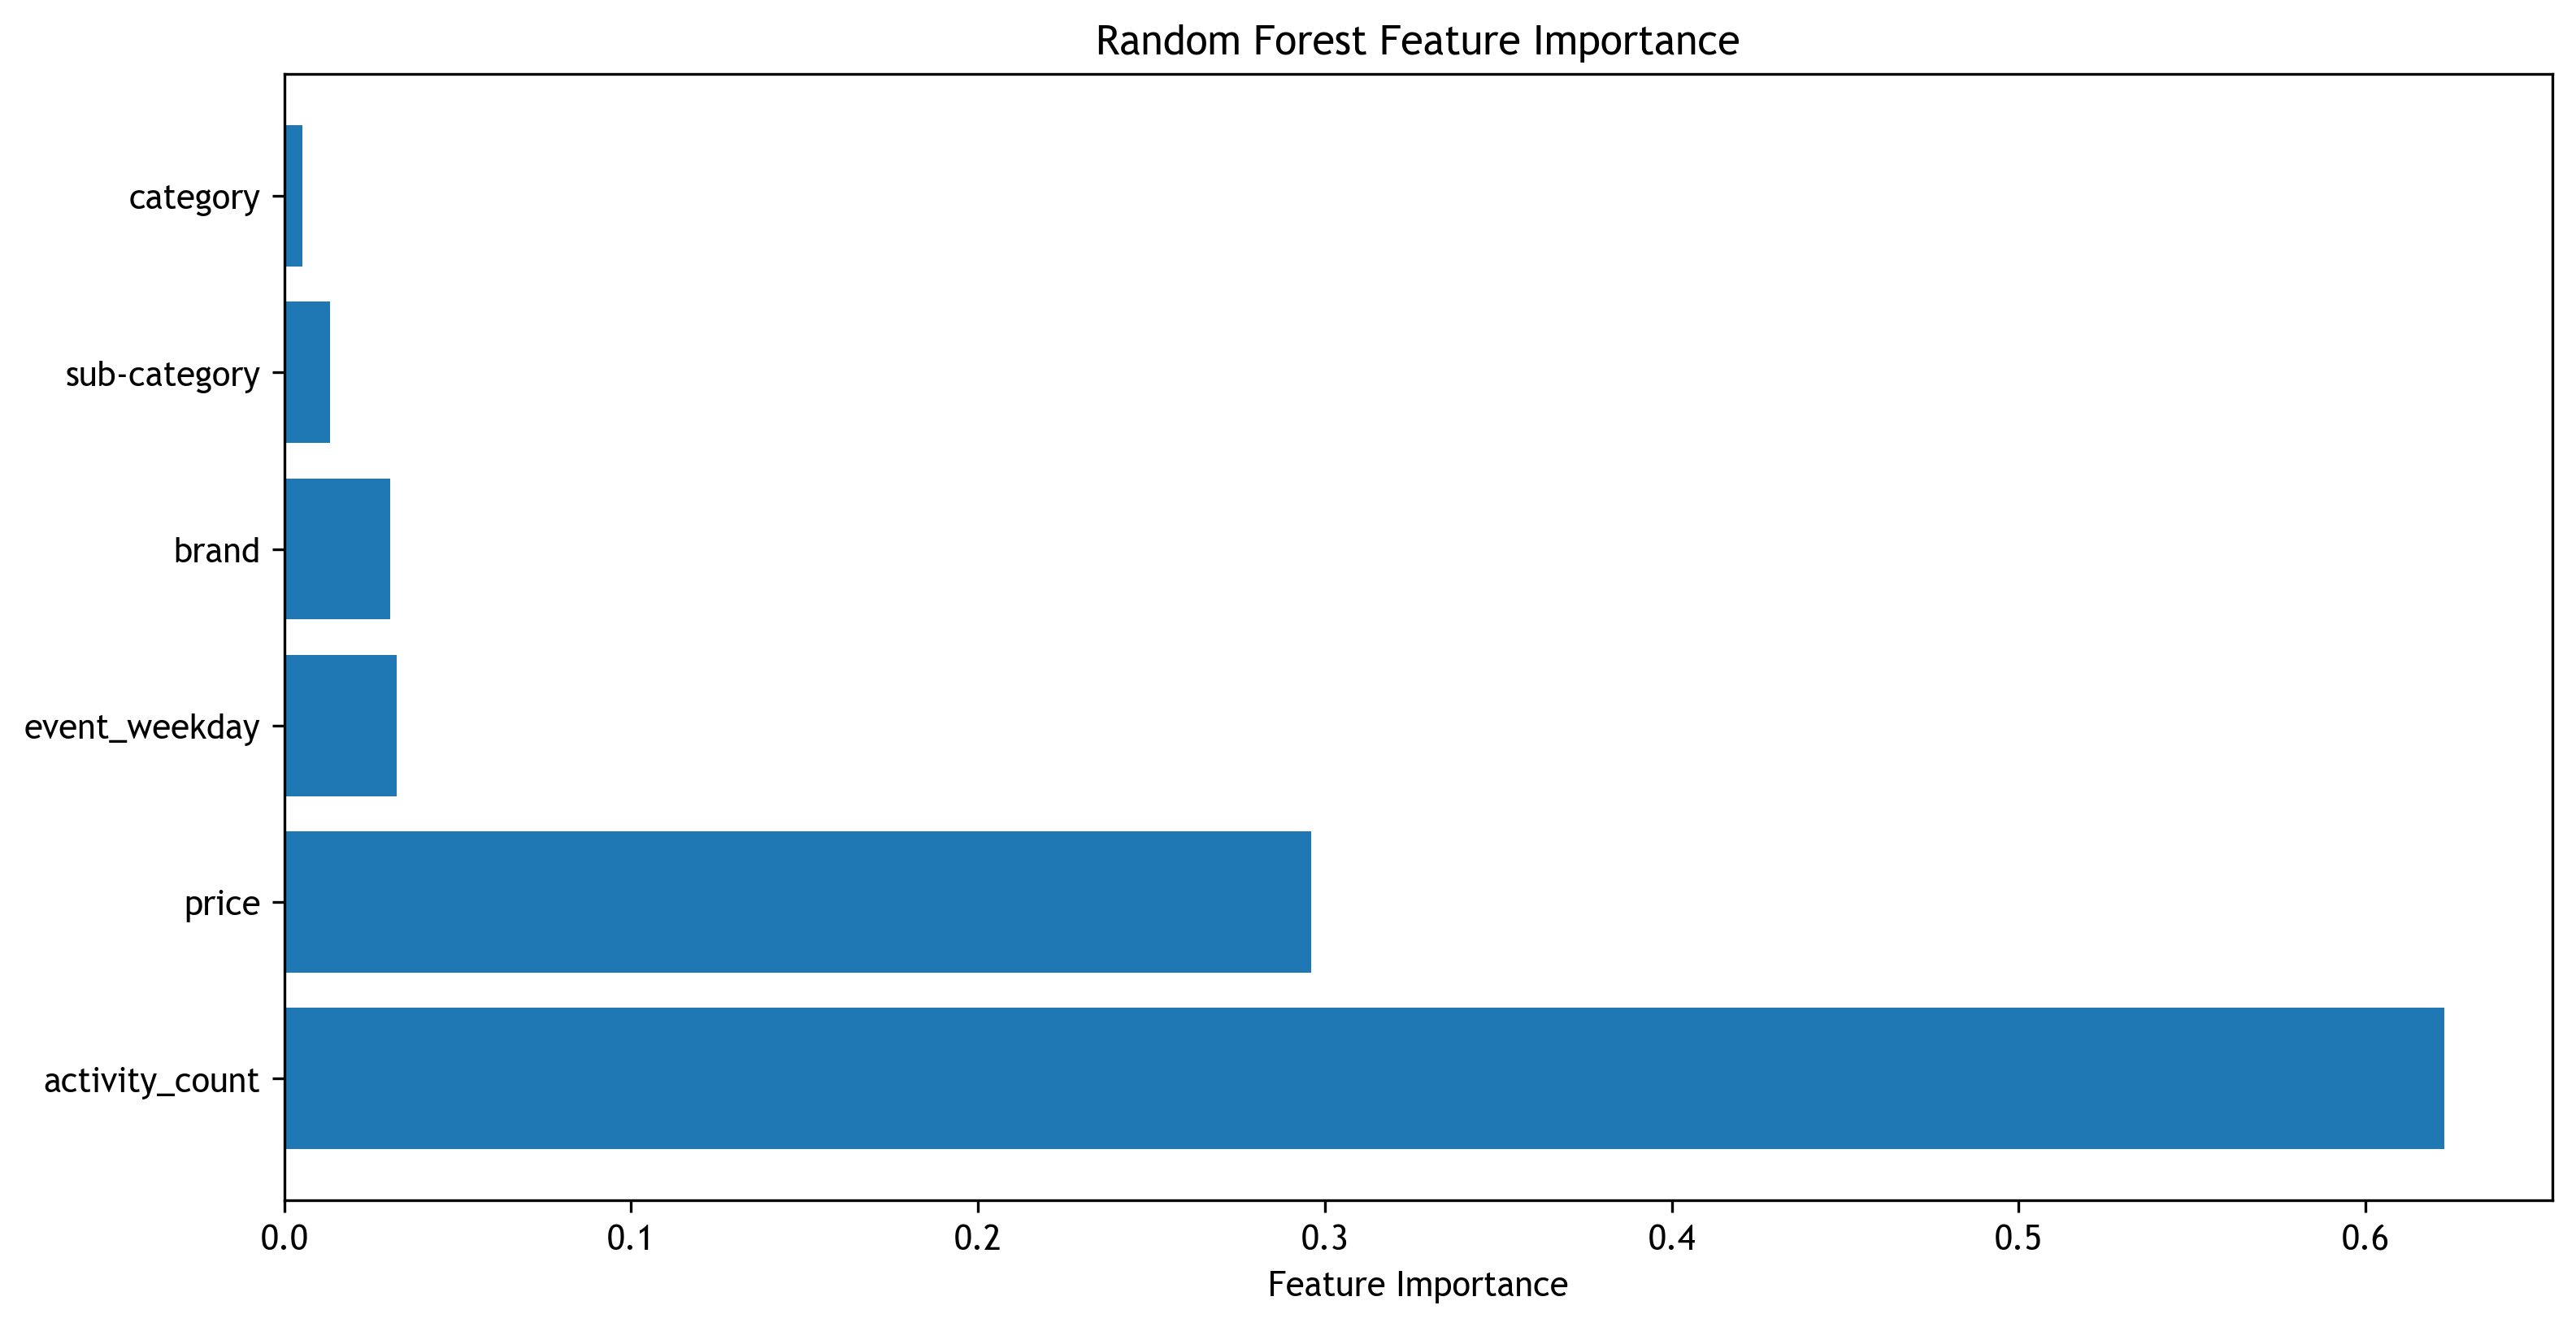

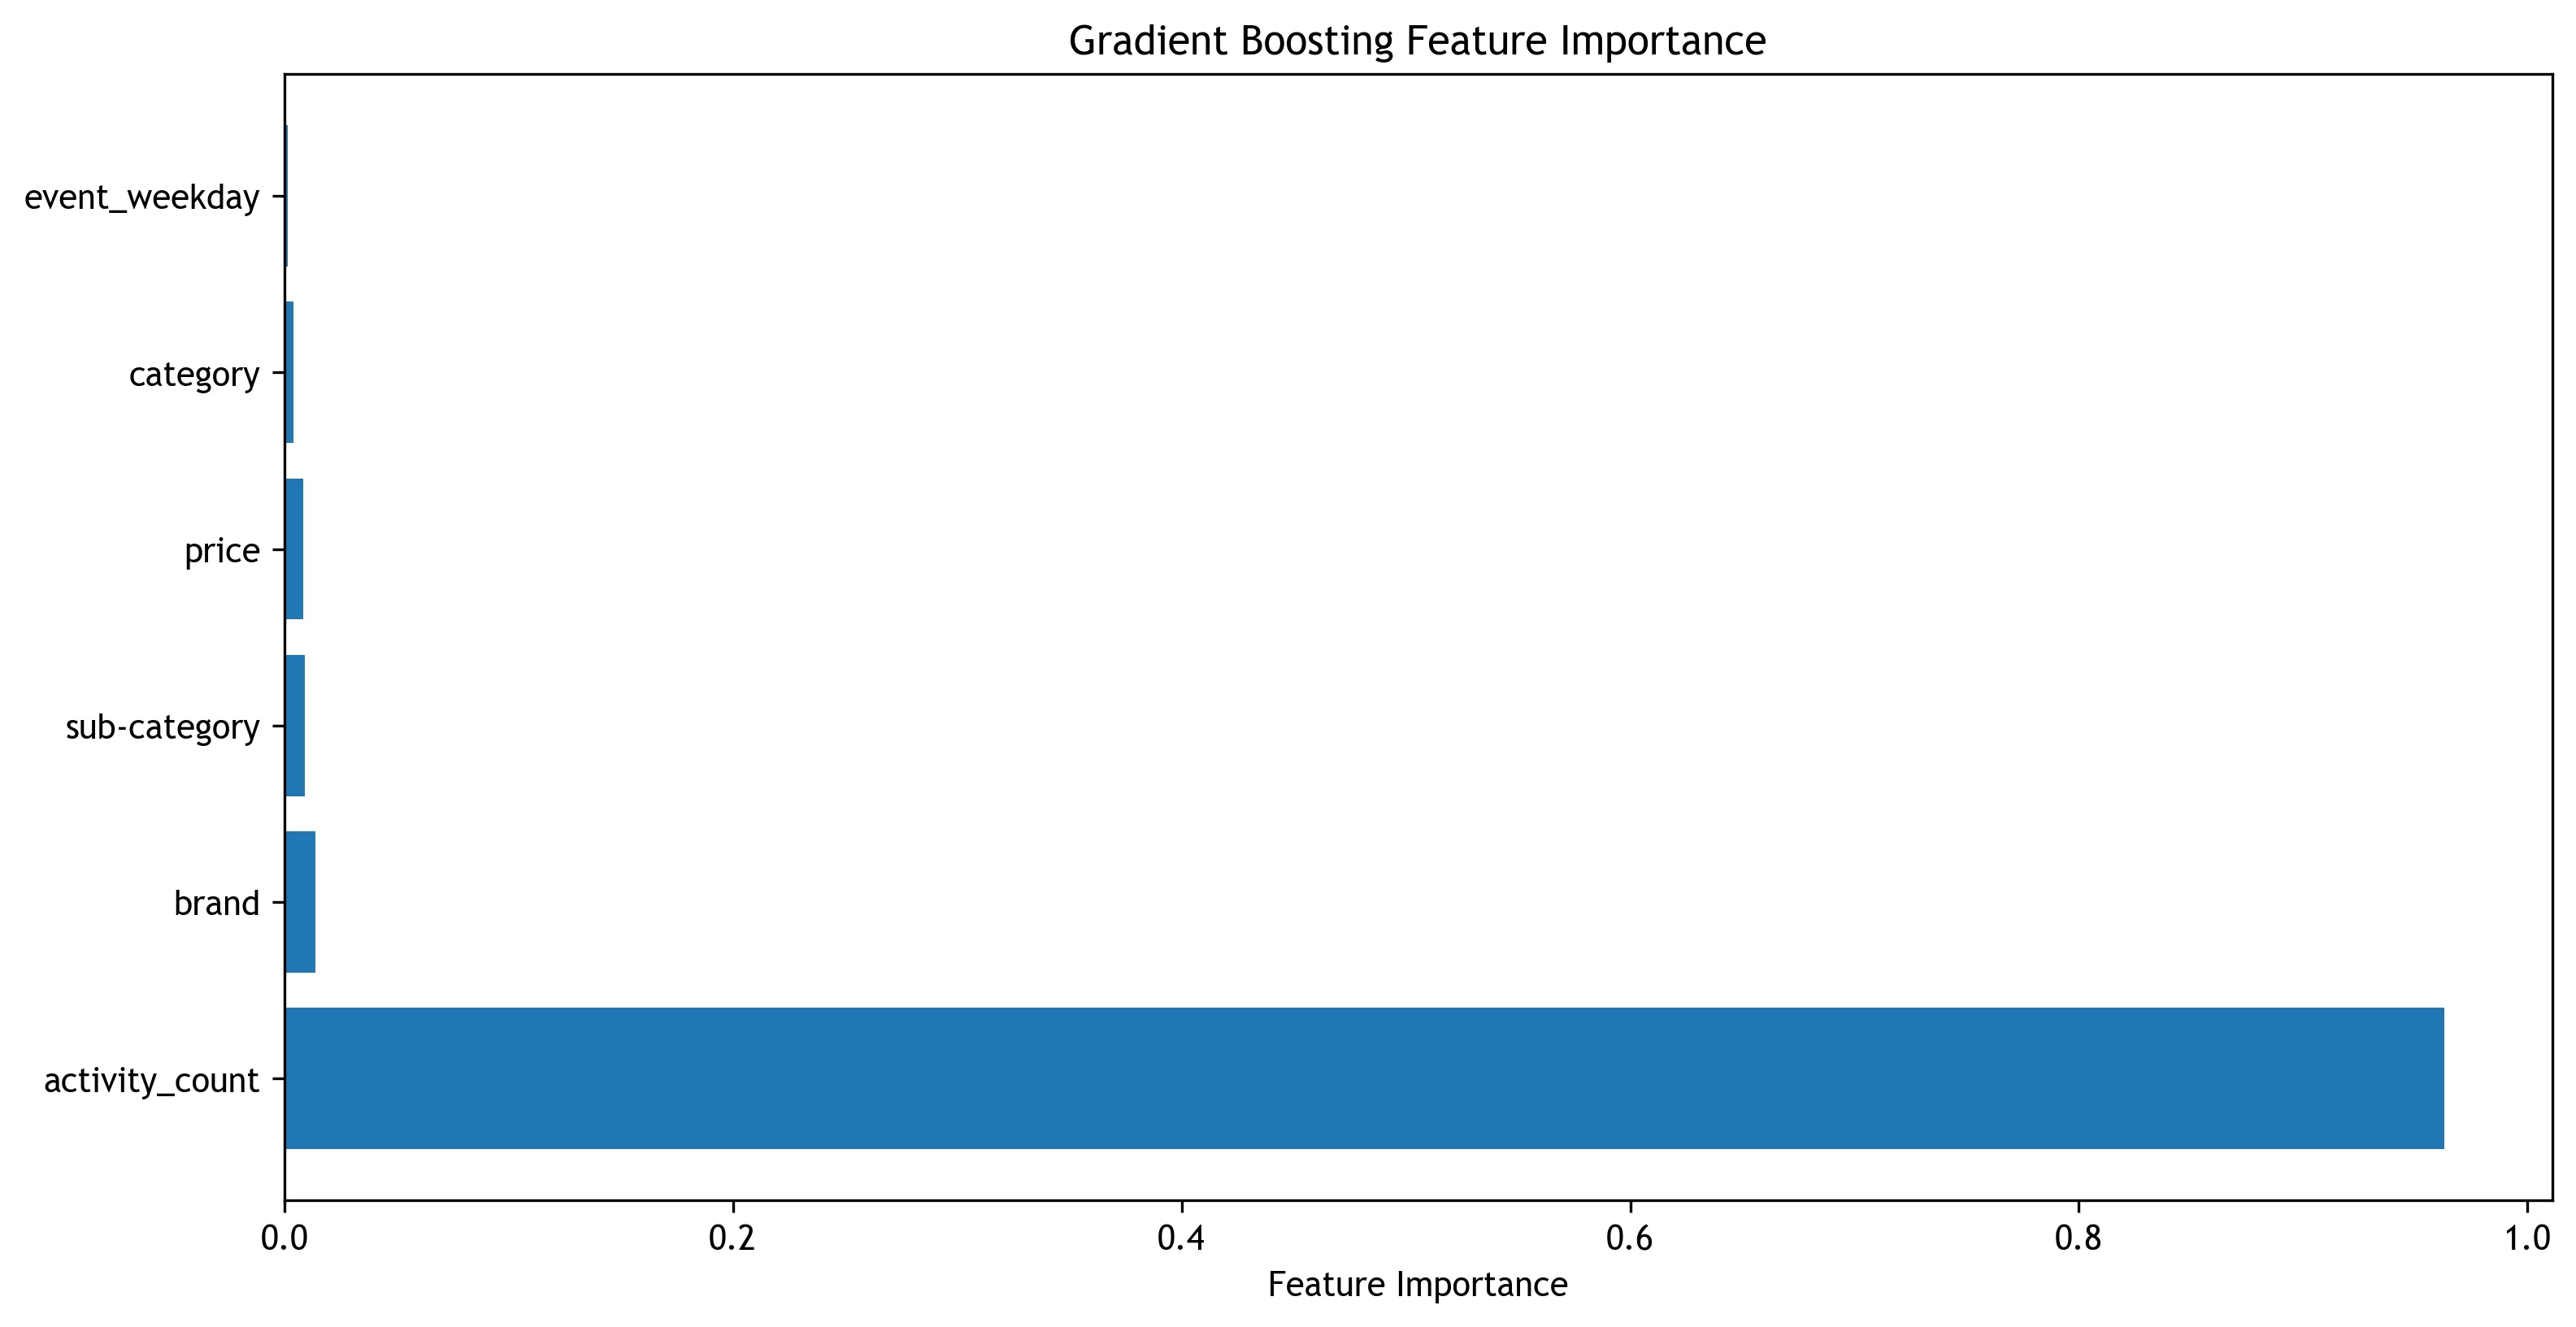

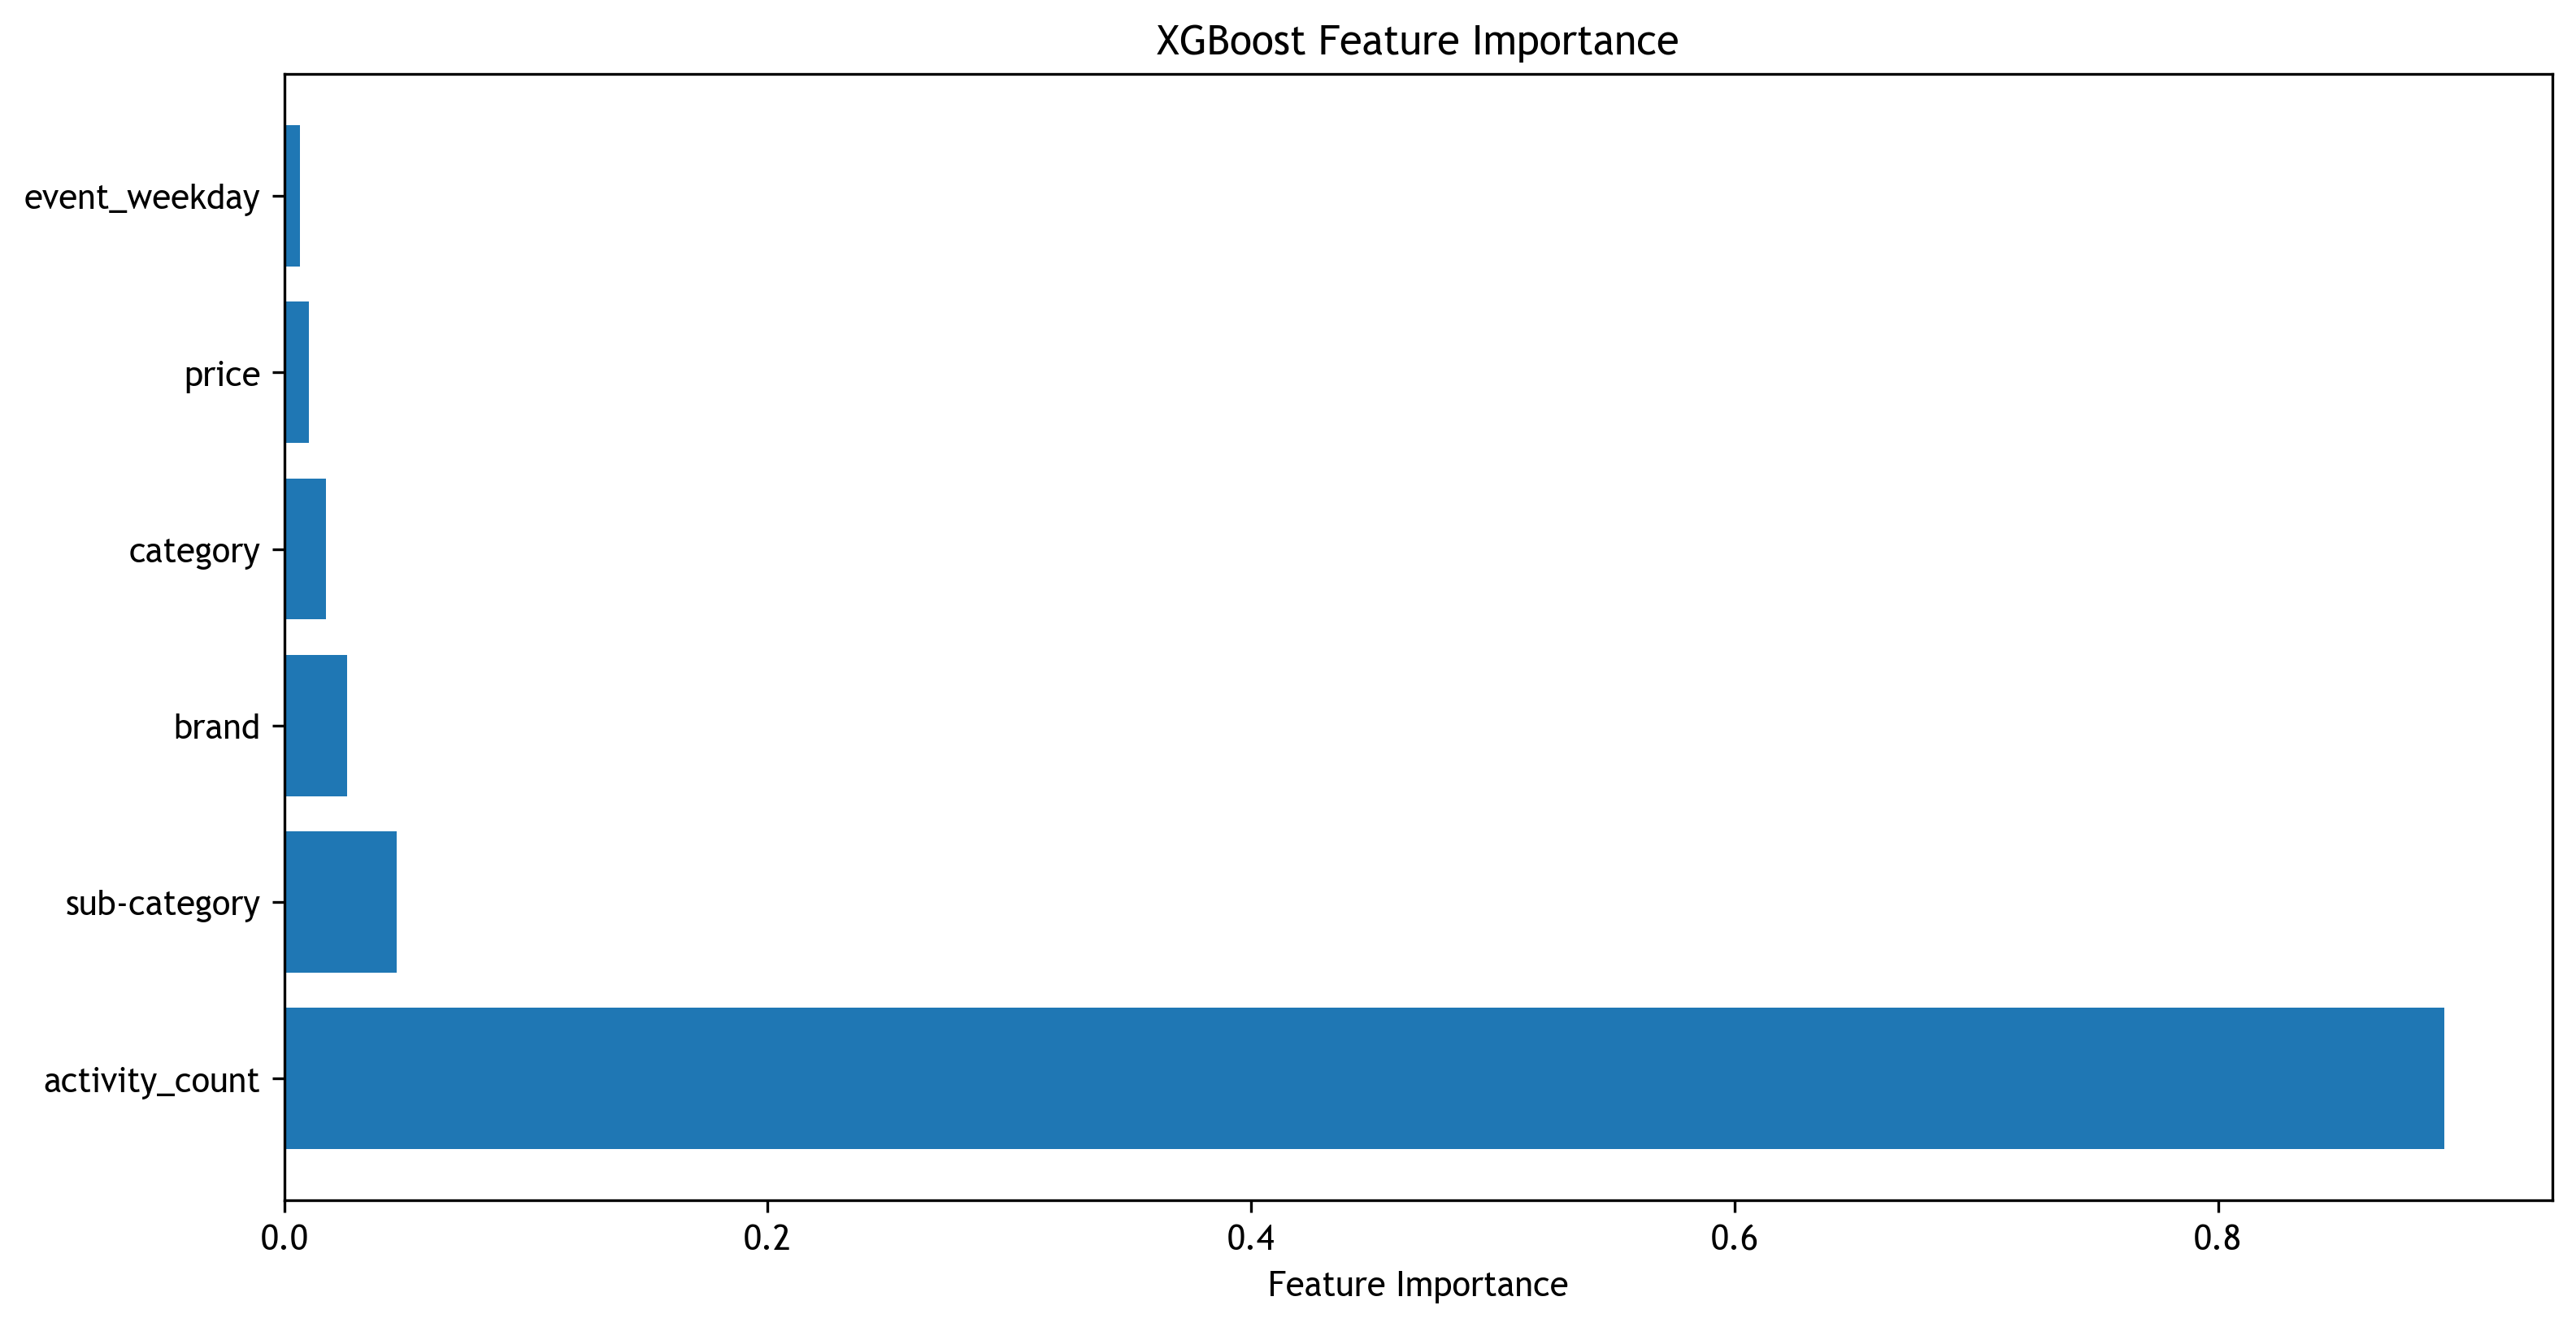

In [19]:
import numpy as np

# Assume we have a list of feature names
feature_cols = X_train.columns

# Plot feature importance for each model
for name, model in models.items():
    plt.figure(figsize=(12, 6), dpi = 300)
    plt.title(f"{name} Feature Importance")
    
    if name == "Logistic Regression":
        # For Logistic Regression, use absolute values of coefficients
        feature_importance = np.abs(model.coef_[0])
    else:
        # For other models, use the feature_importances_ attribute
        feature_importance = model.feature_importances_
    
    # Sort the features by importance in descending order
    indices = np.argsort(feature_importance)[::-1]
    
    # Plot feature importance
    plt.barh(np.array(feature_cols)[indices], feature_importance[indices])
    plt.xlabel('Feature Importance')
    plt.show()


In [20]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize the XGBoost model with hyperparameters
xgb_model = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    max_depth=8,
    min_child_weight=4,
    gamma=0.1,
    subsample=0.8,
    objective= 'binary:logistic',
    colsample_bytree=0.5,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42
)

# Train the model on the training data
print("Training the XGBoost model...")
xgb_model.fit(X_train, y_train)
print("Training complete.")

# Make predictions on the test set
y_pred = xgb_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Training the XGBoost model...
Training complete.
Accuracy: 76.42%


In [22]:
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency

# Create a confusion matrix
confusion = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(confusion)

# Perform the Chi-Square test
chi_sq, p, _, _ = chi2_contingency(confusion)

print("\nChi-Square Value =", round(chi_sq, 3))
print("P Value =", p)

# Interpretation of the p-value
alpha = 0.05
if p <= alpha:
    print("There is a significant relationship between observed values model predictions.")
else:
    print("There is no significant relationship between observed values model predictions.")


Confusion Matrix:
[[44134 37682]
 [  989 81175]]

Chi-Square Value = 57165.85
P Value = 0.0
There is a significant relationship between observed values model predictions.
